In [2]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);



In [86]:
class Taylorizer:
    """Perform taylor expansion of tensor using pre-computed expansion weights"""
    def __init__(self, mGridPmt, mGridCoord, pad=1, Lambda=0.5):
        """
        mGridPmt:   numpy array with (Height,Width) only significance is
                    1. value should be unique for each grid site
                    2. if no PMT exists, set to -1
        mGridCoord: numpy array with (Ncoords,Height,Width)
        pad:        the taylor expansion will be performed on a grid with sides 2*pad+1
        Lambda:     the regularization strength. should be something of order the differences in mGridCoord
        """
        
        self.mGridPmt   = mGridPmt
        self.mGridCoord = mGridCoord
        self.pad = pad
        self.Lambda = Lambda
        self.AA = self.computeTaylorWeights()
    
    def cuda(self):
        self.AA = self.AA.cuda()
    
    def cpu(self):
        self.AA = self.AA.cpu()
        
    def __call__(self, inputs):
        return self.taylorize(inputs)

    def computeTaylorWeights(self):
        pad = self.pad
        mGridPmt = self.mGridPmt
        mGridCoord = self.mGridCoord

        Ncoords = mGridCoord.shape[0]
        Ntaylor = 1 + Ncoords # + (Ncoords*(Ncoords+1))//2
        self.Ntaylor = Ntaylor

        M = mGridPmt.shape[0]
        mGridI = np.reshape(np.repeat(np.arange(M),M), (M,M))
        mGridJ = mGridI.transpose()

        Nshift = 2*pad+1
        dij = np.reshape(np.repeat(np.arange(-pad,pad+1),Nshift), (Nshift,Nshift));
        dis = dij.flatten()
        djs = dij.transpose().flatten();
        Nsites = dis.size;
        
        self.dis = dis
        self.djs = djs
        self.Nsites = Nsites

        mGridPmtpad = geometricPad(torch.tensor(mGridPmt).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridIpad = geometricPad(torch.tensor(mGridI).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();
        mGridJpad = geometricPad(torch.tensor(mGridJ).unsqueeze(0).unsqueeze(0), pad).squeeze(0).squeeze(0).numpy();

        mGridCoordPad = geometricPad(torch.tensor(mGridCoord).unsqueeze(0), pad).squeeze(0).numpy();


        mGridAA2 = np.zeros((M,M,Nshift,Nshift,Ntaylor))

        pmtI1 = mGridPmt[:,:]; # index in tank.pmt

        x      = np.zeros((Ncoords,M,M,Nsites));     # coordinates for each direction
        skip   = np.zeros((M,M,Nsites), dtype=bool); # for each direction whether we should skip or not
        processedPmtI2s = np.zeros((M,M,Nsites), dtype=int) - 1;

        for diji in range(Nsites):
            di = dis[diji]
            dj = djs[diji]
            # i2 = mGridIpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            # j2 = mGridJpad[pad+di:pad+M+di,pad+dj:pad+M+dj];
            pmtI2 = mGridPmtpad[(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)];
            processedPmtI2s[:,:,diji] = pmtI2;

            skip[:,:,diji] = np.logical_or(np.equal(pmtI1,-1), np.equal(pmtI2,-1));
            for prev_diji in range(diji):
                skip[:,:,diji] = np.logical_or(skip[:,:,diji], np.equal(processedPmtI2s[:,:,prev_diji],pmtI2));

            x[:,:,:,diji] = mGridCoordPad[:,(pad+di):(pad+M+di),(pad+dj):(pad+M+dj)] - mGridCoord; # 

        # x: (Ncoords,M,M,Nsites)
        # print('x.shape:', x.shape)
        # X: (Ntaylor,M,M,Nsites)
        Xlist = [np.expand_dims(np.ones(x.shape[1:]),0),x]
        #for i in range(Ncoords):
        #    Xlist.append(np.stack([x[i,:,:,:] for j in range(Ncoords-i)]) * x[i:,:,:,:])
        X = np.concatenate(Xlist)
        # print('X.shape:', X.shape)
        X = np.where(np.expand_dims(skip, 0), 0., X);

        # regularization strength
        Lambda = self.Lambda; # this should be somewhat smaller than typical values of x

        MA = np.zeros((M,M,Nsites,Nsites));
        for k in range(Nsites):
            for j in range(Nsites):
                MA[:,:,k,j] = np.add(np.sum(X[:,:,:,k]*X[:,:,:,j], axis=0), Lambda**2 * (k==j));
            # clear skip entries
            MA[:,:,k,:] = np.where(np.expand_dims(skip[:,:,k],-1), 0., MA[:,:,k,:]);
            MA[:,:,:,j] = np.where(np.expand_dims(skip[:,:,j],-1), 0., MA[:,:,:,j]);
            # set diagonal:
            MA[:,:,k,k] = np.where(skip[:,:,k], 1., MA[:,:,k,k]);

        #print('MA.shape:',MA.shape)
        #print(MA[0,1,:,:])
        #print(np.linalg.inv(MA[0,1,:,:]))
        print("starting inversion... (may take a few seconds)")
        AA = np.einsum('hwsi,thwi->thws', np.linalg.inv(MA), X)
        print("done")
        # print('AA.shape:', AA.shape)
        return torch.tensor(AA, dtype=torch.float)
    
    def taylorize(self, inputs):
        Batches = inputs.shape[0]
        ChIn    = inputs.shape[1]
        Height  = inputs.shape[2]
        Width   = inputs.shape[3]
        tGridAA = self.AA

        inputsPad = geometricPad(inputs, self.pad); # (B,C,W,H)
        tayloredInput = inputs.new_zeros((Batches, self.Ntaylor, ChIn, Height, Width))
        
        #print('tGridAA.shape:', tGridAA.shape)
        #print('tayloredInput.shape:', tayloredInput.shape)
        #print('inputsPad.shape:', inputsPad.shape)
        for k in range(self.Nsites):
            # shift grid according to position (without copying the data)
            inputsPadD1 = torch.narrow(inputsPad,   2, self.pad+int(self.dis[k]), Height)
            inputsPadD2 = torch.narrow(inputsPadD1, 3, self.pad+int(self.djs[k]), Width )
            # fill
            out = torch.add(tayloredInput, torch.einsum('dij,bcij->bdcij', tGridAA[:,:,:,k], inputsPadD2))
            tayloredInput = out

        return tayloredInput.view(Batches, self.Ntaylor*ChIn, Height, Width)
    
    def pool2d(self, kernel_size, pad=-1, Lambda=-1.):
        """
        Return new Taylorizer that can be used for the result of a 2d pool operation with given kernel size.
        kernel_size: e.g. for 2x2 max-pooling use (2,2)
        pad:    if unset (-1)  use same as current
        Lambda: if unset (-1.) use same as current
        """
        mGridPmt1   = torch.nn.functional.max_pool2d(torch.tensor(self.mGridPmt  ).to(torch.float).unsqueeze(0), kernel_size).squeeze(0).to(torch.long).numpy()
        mGridFilled1 = torch.nn.functional.avg_pool2d(torch.tensor((self.mGridPmt >= 0).astype(float)).unsqueeze(0), kernel_size).squeeze(0).numpy()
        
        mGridCoord1 = torch.nn.functional.avg_pool2d(torch.tensor(self.mGridCoord), kernel_size).numpy()
        mGridCoord1 /= mGridFilled1 # correct average for missing positions
        
        if (pad < 0):
            pad = self.pad
        if (Lambda < 0.):
            Lambda = self.Lambda
        
        return Taylorizer(mGridPmt1, mGridCoord1, pad=pad, Lambda=Lambda)

In [87]:
f = h5py.File('/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat/1Rmu-blacksheet/wc-0-bch1.h5','r')
event_data = f['event_data'][:]

In [88]:
mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
    f['mGridX'][()]/20.,
    f['mGridY'][()]/20.,
    f['mGridZ'][()]/20.,
    f['mGridDirX'][()],
    f['mGridDirY'][()],
    f['mGridDirZ'][()]
])

taylor0 = Taylorizer(mGridPmt, mGridCoord, pad=1, Lambda=1.)

starting inversion... (may take a few seconds)
done


In [117]:
# filters = torch.randn(Cout,Cin,Hflt,Wflt);
inputs = torch.tensor(event_data[(0,5),:,:,0]).unsqueeze(1);
tayloredInput = taylor0(inputs)


def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)


for ev in range(tayloredInput.shape[0]):
    print(ev)
    taylorTitles = ['1','x','y','z','dir_x','dir_y','dir_z']
    fig, axes = plt.subplots(1, taylor0.Ntaylor, figsize=(16,8),facecolor='w')
    for itaylor in range(taylor0.Ntaylor):
        imshowRdBu(axes[itaylor], tayloredInput[ev,itaylor,:,:]); axes[itaylor].set_title(taylorTitles[itaylor])
    plt.show()

RuntimeError: expected type torch.cuda.FloatTensor but got torch.FloatTensor

In [65]:
inputs1 = torch.nn.functional.max_pool2d(inputs, (2,2))
print('inputs.shape ', inputs.shape)
print('inputs1.shape', inputs1.shape)

inputs.shape  torch.Size([2, 1, 105, 105])
inputs1.shape torch.Size([2, 1, 52, 52])


In [66]:
mGridPmt1   = torch.nn.functional.max_pool2d(torch.tensor(mGridPmt  ).to(torch.float).unsqueeze(0), (2,2)).squeeze(0).to(torch.long).numpy()
print('mGridPmt.shape ', mGridPmt.shape)
print('mGridPmt1.shape', mGridPmt1.shape)

mGridFilled1 = torch.nn.functional.avg_pool2d(torch.tensor((mGridPmt >= 0).astype(float)).unsqueeze(0), (2,2)).squeeze(0).numpy()

mGridCoord1 = torch.nn.functional.avg_pool2d(torch.tensor(mGridCoord), (2,2)).numpy()
mGridCoord1 /= mGridFilled1
print('mGridCoord.shape ', mGridCoord.shape)
print('mGridCoord1.shape', mGridCoord1.shape)

mGridPmt.shape  (105, 105)
mGridPmt1.shape (52, 52)
mGridCoord.shape  (6, 105, 105)
mGridCoord1.shape (6, 52, 52)


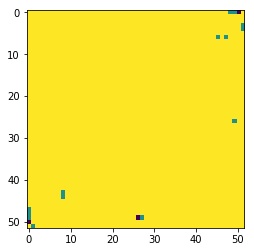

In [67]:
plt.imshow(mGridFilled1)
plt.show()

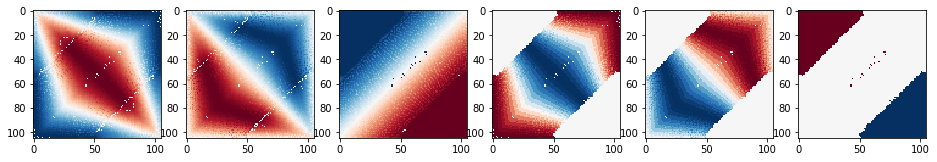

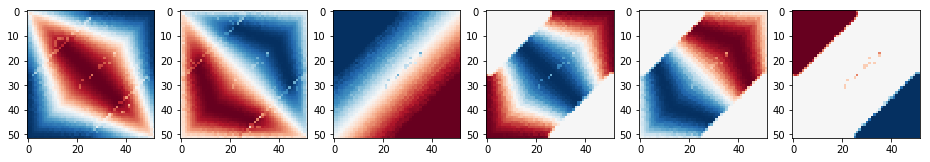

In [68]:
fig, axes = plt.subplots(1, mGridCoord.shape[0], figsize=(16,8),facecolor='w')
for i in range(mGridCoord.shape[0]):
    imshowRdBu(axes[i], torch.tensor(mGridCoord[i,:,:]))
plt.show()

fig, axes = plt.subplots(1, mGridCoord1.shape[0], figsize=(16,8),facecolor='w')
for i in range(mGridCoord.shape[0]):
    imshowRdBu(axes[i], torch.tensor(mGridCoord1[i,:,:]))
plt.show()

In [69]:
kernel_size = (2,2)
inputs1 = torch.nn.functional.max_pool2d(inputs, kernel_size)
taylor1 = taylor0.pool2d(kernel_size)

starting inversion... (may take a few seconds)
done


tGridAA.shape: torch.Size([7, 52, 52, 9])
tayloredInput.shape: torch.Size([2, 7, 1, 52, 52])
inputsPad.shape: torch.Size([2, 1, 54, 54])
0


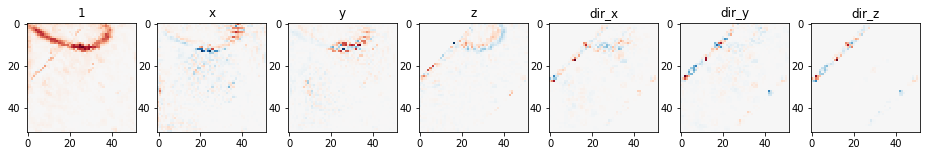

1


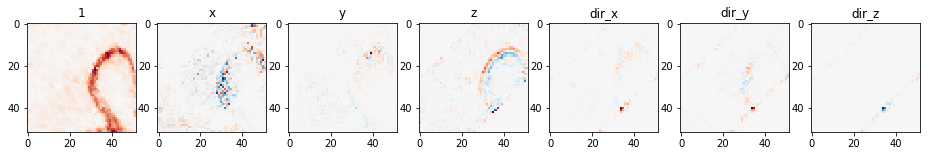

In [70]:
tayloredInput1 = taylor1(inputs1)

for ev in range(tayloredInput.shape[0]):
    print(ev)
    taylorTitles = ['1','x','y','z','dir_x','dir_y','dir_z']
    fig, axes = plt.subplots(1, taylor1.Ntaylor, figsize=(16,8),facecolor='w')
    for itaylor in range(taylor1.Ntaylor):
        imshowRdBu(axes[itaylor], tayloredInput1[ev,itaylor,:,:]); axes[itaylor].set_title(taylorTitles[itaylor])
    plt.show()

In [71]:
kernel_size = (2,2)
inputs2 = torch.nn.functional.max_pool2d(inputs1, kernel_size)
print(inputs2.shape)
taylor2 = taylor1.pool2d(kernel_size)
print(taylor2.AA.shape)

torch.Size([2, 1, 26, 26])
starting inversion... (may take a few seconds)
done
torch.Size([7, 26, 26, 9])


tGridAA.shape: torch.Size([7, 26, 26, 9])
tayloredInput.shape: torch.Size([2, 7, 1, 26, 26])
inputsPad.shape: torch.Size([2, 1, 28, 28])
0


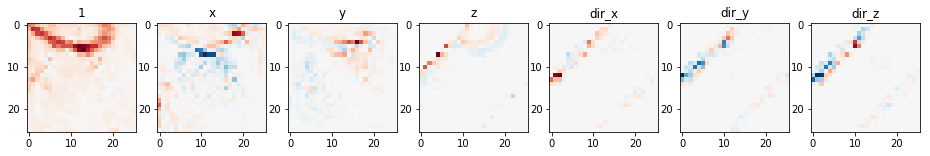

1


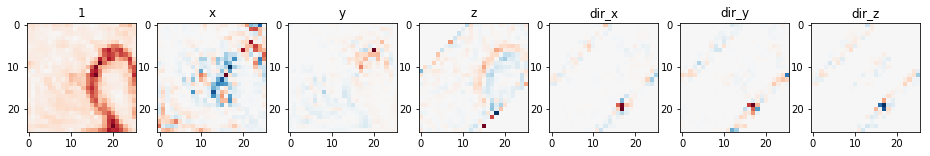

In [72]:
tayloredInput2 = taylor2(inputs2)

for ev in range(tayloredInput.shape[0]):
    print(ev)
    taylorTitles = ['1','x','y','z','dir_x','dir_y','dir_z']
    fig, axes = plt.subplots(1, taylor2.Ntaylor, figsize=(16,8),facecolor='w')
    for itaylor in range(taylor2.Ntaylor):
        imshowRdBu(axes[itaylor], tayloredInput2[ev,itaylor,:,:]); axes[itaylor].set_title(taylorTitles[itaylor])
    plt.show()

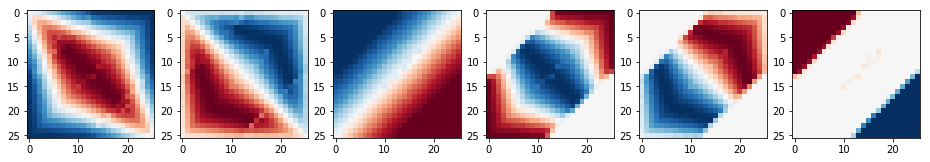

In [73]:
fig, axes = plt.subplots(1, taylor2.mGridCoord.shape[0], figsize=(16,8),facecolor='w')
for i in range(taylor2.mGridCoord.shape[0]):
    imshowRdBu(axes[i], torch.tensor(taylor2.mGridCoord[i,:,:]))
plt.show()

## Train network

In [76]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        event_data[:,:,1] = np.where(event_data[:,:,0] > 0., event_data[:,:,1]-900., 0.) # shift center
        event_data[:,:,1] = np.where(np.abs(event_data[:,:,1]) > 100., 0., event_data[:,:,1]) # remove large variance
        return event_data,label,idx
        #return fh['event_data'][entry_index],np.stack([np.sum(fh['energies'][entry_index,:])]),idx
        #labels = (fh['energies'][entry_index,0]>500.)-0
        #return fh['event_data'][entry_index],labels,idx

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

In [77]:
# also add more data

mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e','mu','pip')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(20) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [82]:
class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        return self.conv2d(self.taylor(x))
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.taylor.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class, taylor):
        super(TaylorCNN, self).__init__()
        
        # prepare taylorizers for maxpool operations
        taylor1 = taylor .pool2d((2,2))
        taylor2 = taylor1.pool2d((2,2))
        taylor3 = taylor2.pool2d((2,2))
        taylor4 = taylor3.pool2d((2,2))
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # taylor conv
            TaylorConv2d( 2,16,taylor), torch.nn.ReLU(),
            TaylorConv2d(16,32,taylor), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(32,32,taylor1), torch.nn.ReLU(),
            TaylorConv2d(32,32,taylor1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(32,64,taylor2), torch.nn.ReLU(),
            TaylorConv2d(64,64,taylor2), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d( 64,128,taylor3), torch.nn.ReLU(),
            TaylorConv2d(128,128,taylor3), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(128,256,taylor4), torch.nn.ReLU(),
            TaylorConv2d(256,256,taylor4), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(256,32), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,256))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [83]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

In [89]:
class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3, taylor0).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


In [90]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-19 06:56:30


Epoch 1 Starting @ 2019-08-19 06:59:14


Epoch 2 Starting @ 2019-08-19 07:01:56


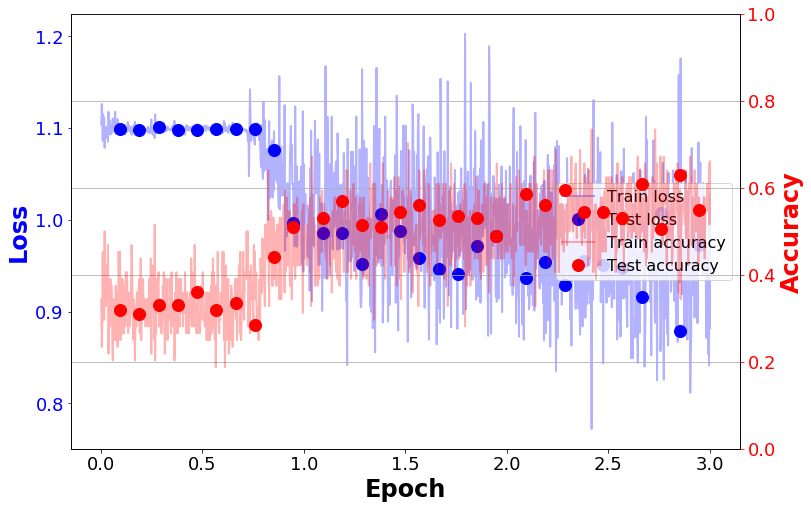

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

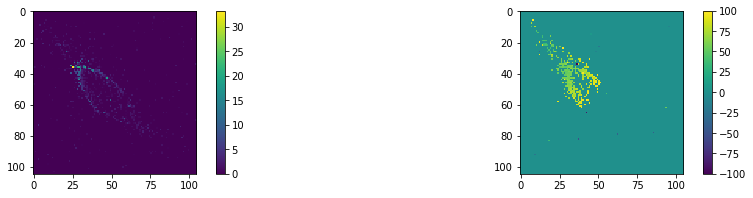

_feature 0 TaylorConv2d(
  (conv2d): Conv2d(14, 16, kernel_size=(1, 1), stride=(1, 1))
)


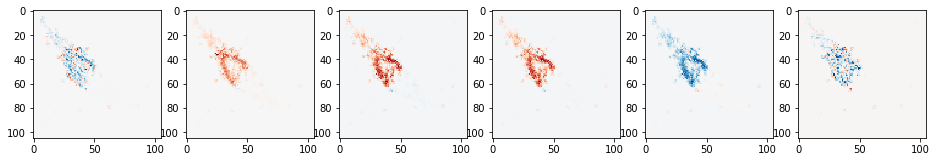

_feature 1 ReLU()


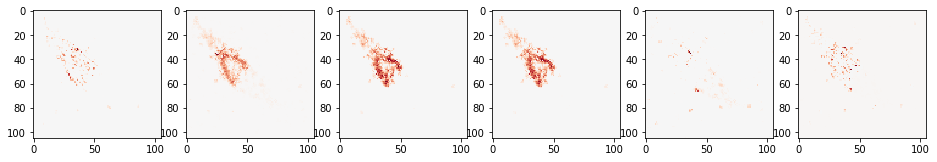

_feature 2 TaylorConv2d(
  (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
)


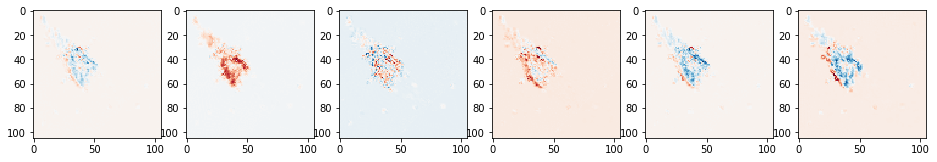

_feature 3 ReLU()


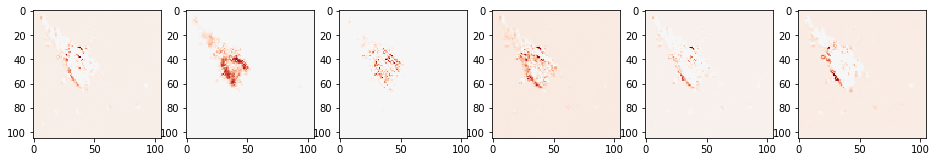

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


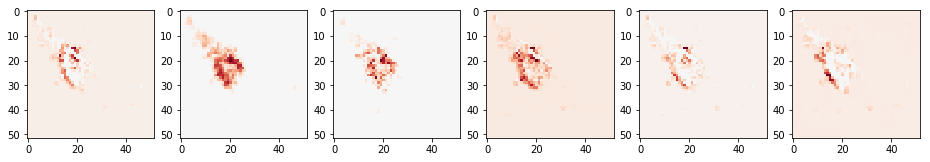

_feature 5 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)


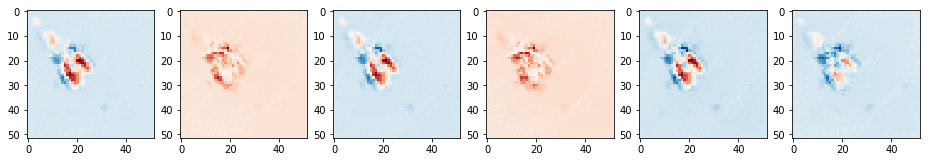

_feature 6 ReLU()


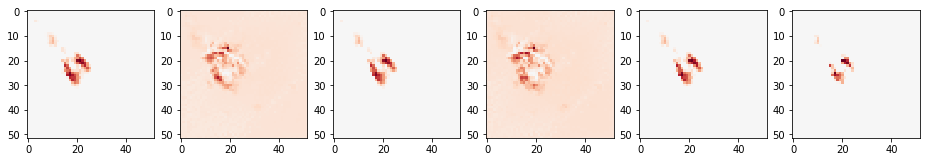

_feature 7 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)


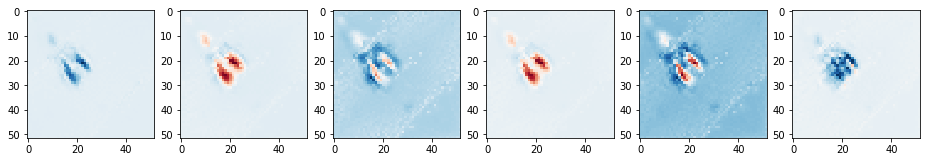

_feature 8 ReLU()


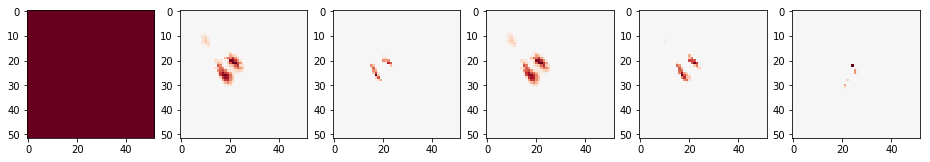

_feature 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


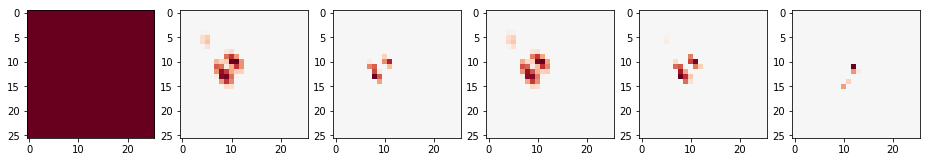

_feature 10 TaylorConv2d(
  (conv2d): Conv2d(224, 64, kernel_size=(1, 1), stride=(1, 1))
)


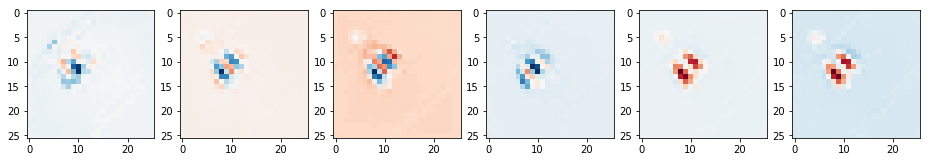

_feature 11 ReLU()


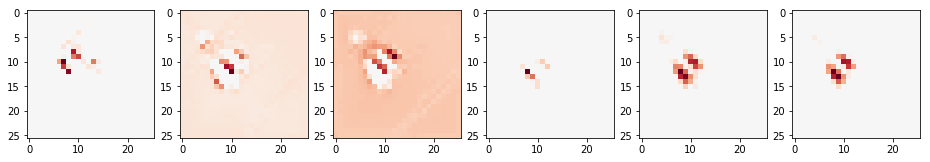

_feature 12 TaylorConv2d(
  (conv2d): Conv2d(448, 64, kernel_size=(1, 1), stride=(1, 1))
)


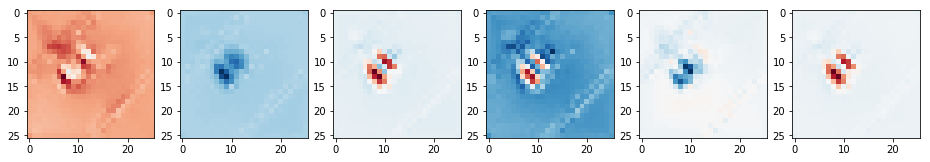

_feature 13 ReLU()


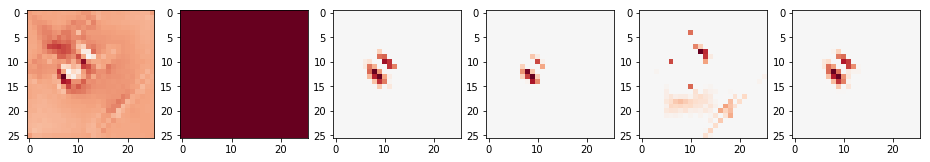

_feature 14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


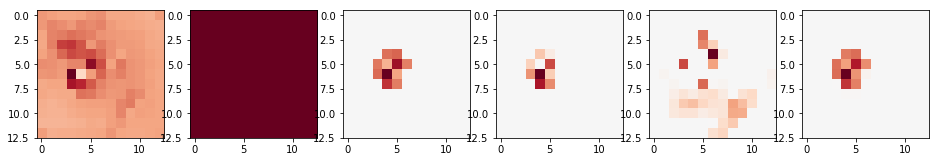

_feature 15 TaylorConv2d(
  (conv2d): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1))
)


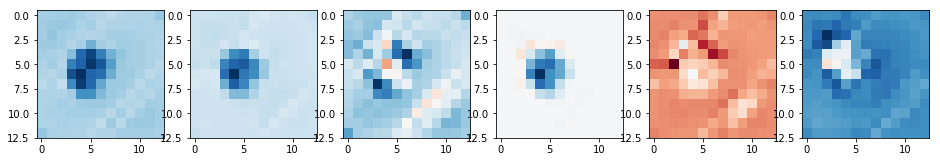

_feature 16 ReLU()


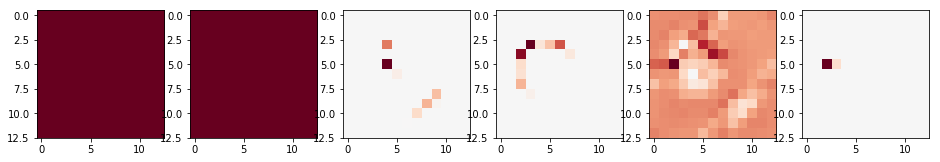

_feature 17 TaylorConv2d(
  (conv2d): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1))
)


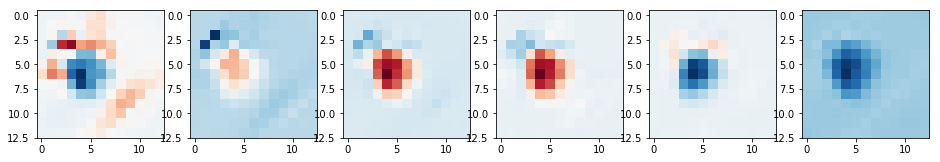

_feature 18 ReLU()


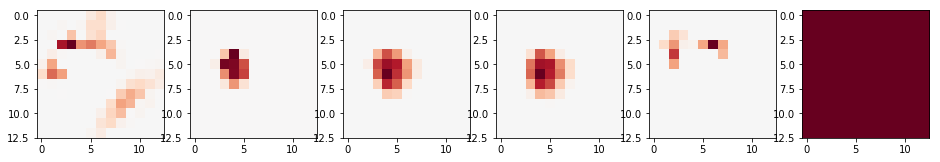

_feature 19 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


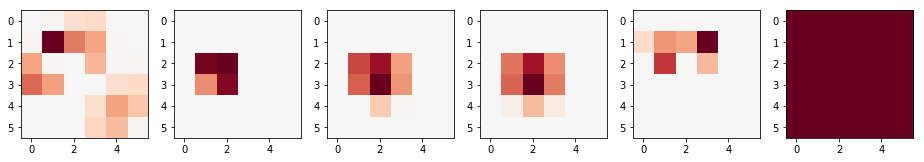

_feature 20 TaylorConv2d(
  (conv2d): Conv2d(896, 256, kernel_size=(1, 1), stride=(1, 1))
)


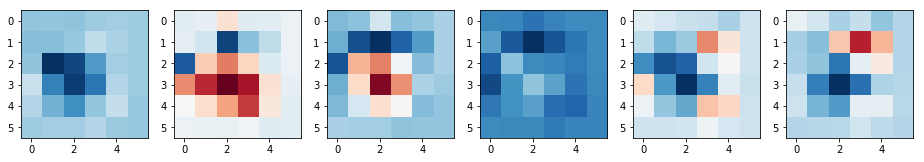

_feature 21 ReLU()


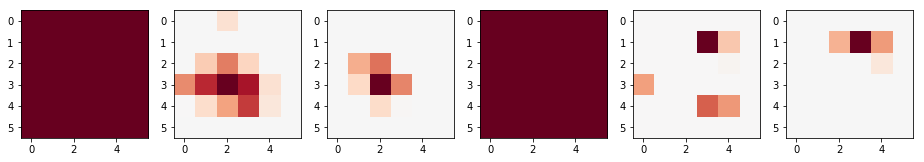

_feature 22 TaylorConv2d(
  (conv2d): Conv2d(1792, 256, kernel_size=(1, 1), stride=(1, 1))
)


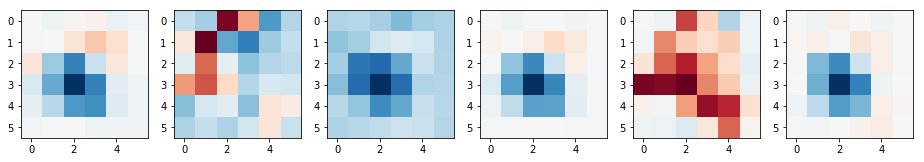

_feature 23 ReLU()


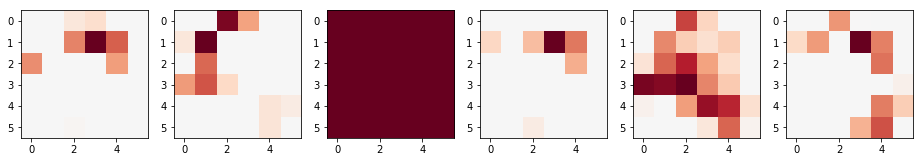

torch.Size([200, 256, 6, 6]) after _feature
torch.Size([200, 256, 1, 1]) after AvgPool2d
torch.Size([200, 256]) after view


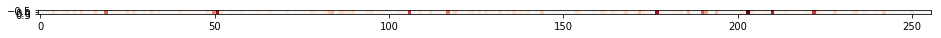

_classifier 0 Linear(in_features=256, out_features=32, bias=True)


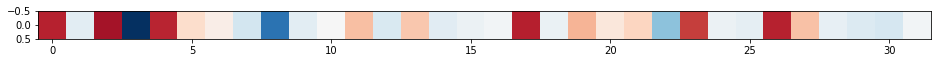

_classifier 1 ReLU()


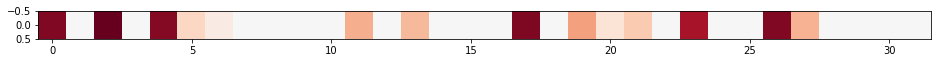

_classifier 2 Linear(in_features=32, out_features=3, bias=True)


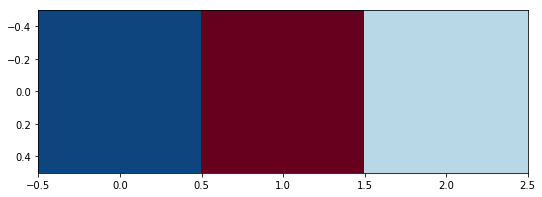

In [92]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    im = ax1.imshow(data[ev,1,:,:].cpu())
    cbar = ax1.figure.colorbar(im, ax=ax1)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        x = module(x)
        fig, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 6, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,0,:,:].cpu())
        imshowRdBu(ax1, x[ev,1,:,:].cpu())
        imshowRdBu(ax2, x[ev,2,:,:].cpu())
        imshowRdBu(ax3, x[ev,3,:,:].cpu())
        imshowRdBu(ax4, x[ev,4,:,:].cpu())
        imshowRdBu(ax5, x[ev,5,:,:].cpu())
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,256)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()

## Train without timing

In [93]:
class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        return self.conv2d(self.taylor(x))
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.taylor.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class, taylor):
        super(TaylorCNN, self).__init__()
        
        # prepare taylorizers for maxpool operations
        taylor1 = taylor .pool2d((2,2))
        taylor2 = taylor1.pool2d((2,2))
        taylor3 = taylor2.pool2d((2,2))
        taylor4 = taylor3.pool2d((2,2))
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # taylor conv
            TaylorConv2d( 1,16,taylor), torch.nn.ReLU(),
            TaylorConv2d(16,32,taylor), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(32,32,taylor1), torch.nn.ReLU(),
            TaylorConv2d(32,32,taylor1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(32,64,taylor2), torch.nn.ReLU(),
            TaylorConv2d(64,64,taylor2), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d( 64,128,taylor3), torch.nn.ReLU(),
            TaylorConv2d(128,128,taylor3), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(128,256,taylor4), torch.nn.ReLU(),
            TaylorConv2d(256,256,taylor4), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(256,32), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,256))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [99]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        return event_data[:,:,0:1],label,idx

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

In [102]:
# also add more data

mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
wallmat = 'blacksheet'
pnames = ('e','mu','pip')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(20) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [103]:
class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3, taylor0).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


In [104]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-19 07:13:13


Epoch 1 Starting @ 2019-08-19 07:15:51


Epoch 2 Starting @ 2019-08-19 07:18:29


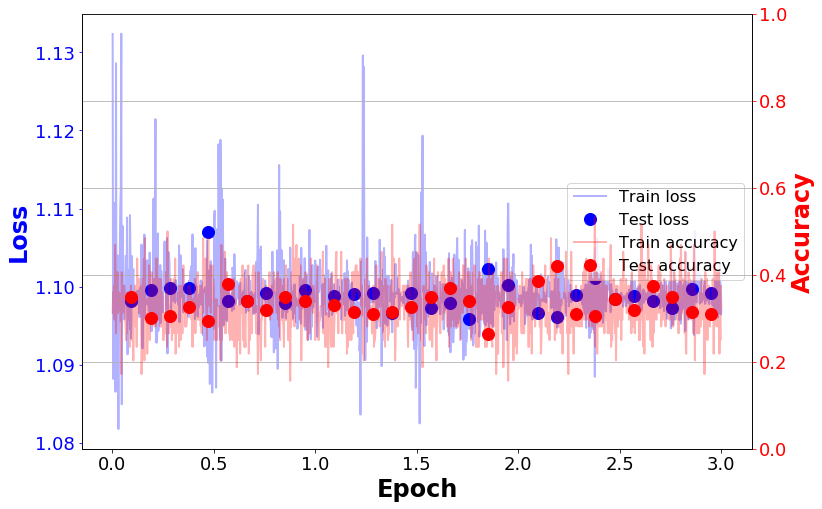

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

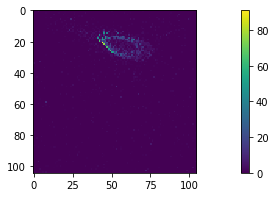

_feature 0 TaylorConv2d(
  (conv2d): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


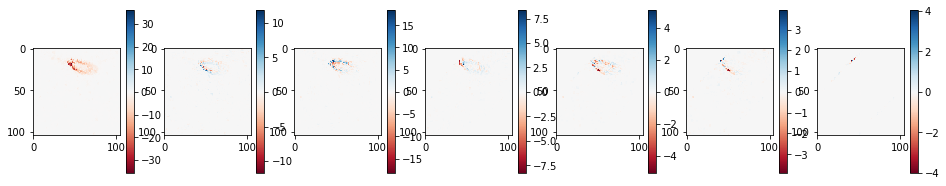

module output:


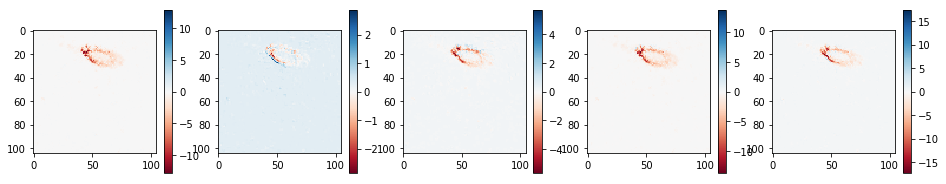

_feature 1 ReLU()


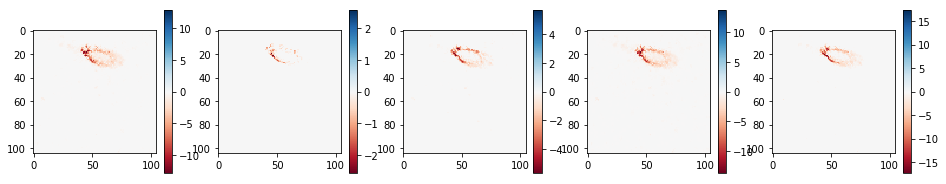

_feature 2 TaylorConv2d(
  (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


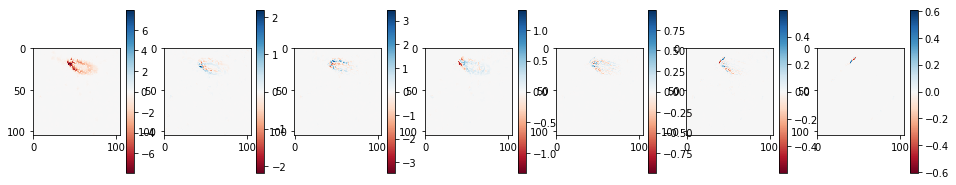

module output:


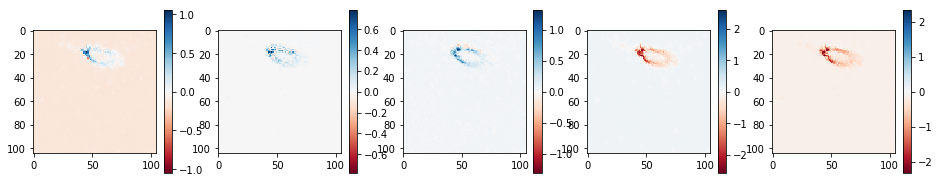

_feature 3 ReLU()


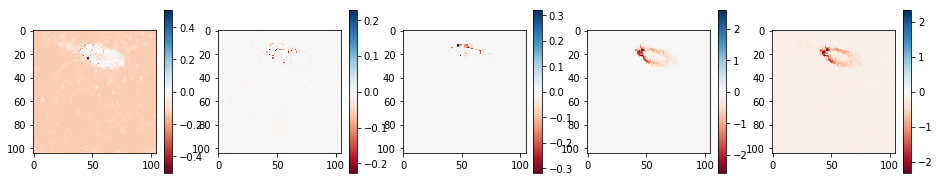

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


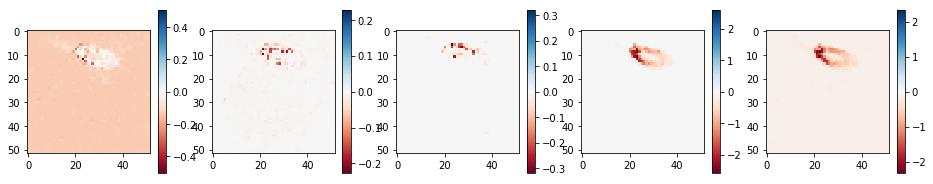

_feature 5 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


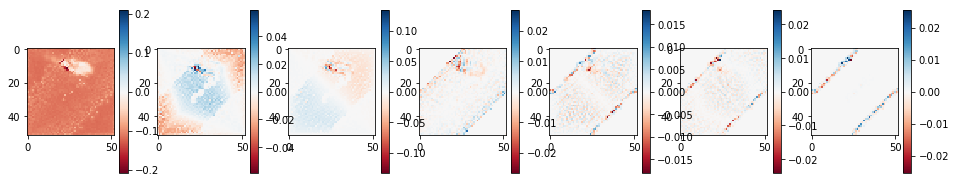

module output:


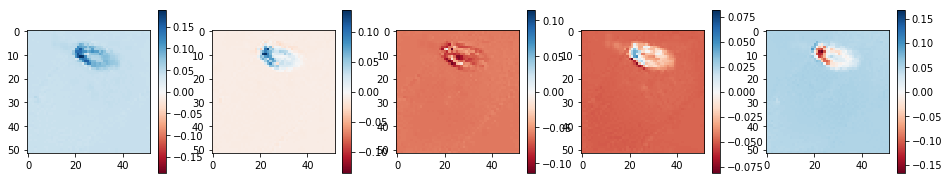

_feature 6 ReLU()


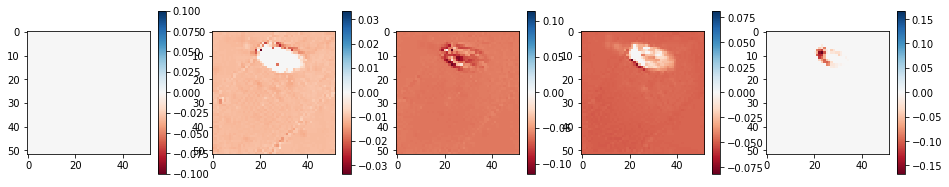

_feature 7 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


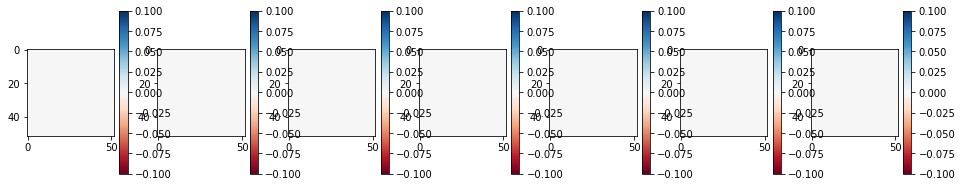

module output:


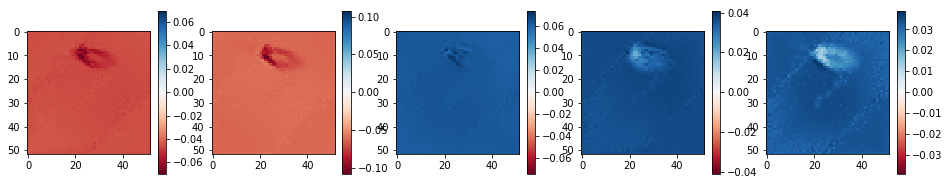

_feature 8 ReLU()


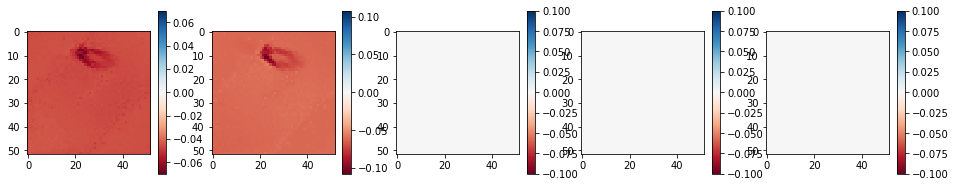

_feature 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


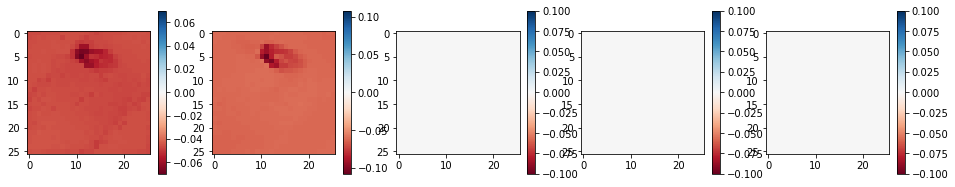

_feature 10 TaylorConv2d(
  (conv2d): Conv2d(224, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


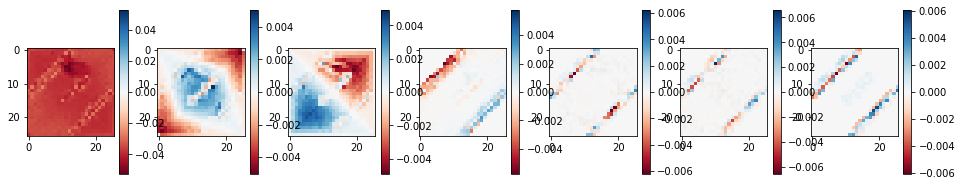

module output:


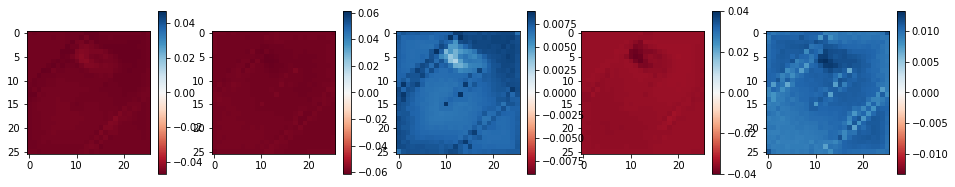

_feature 11 ReLU()


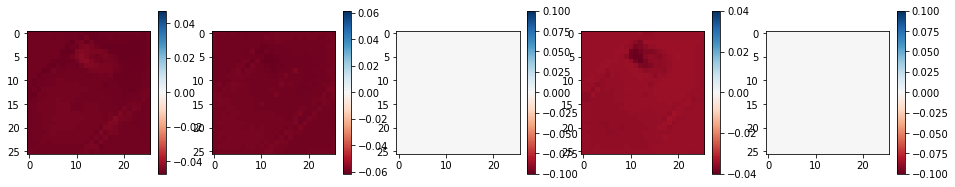

_feature 12 TaylorConv2d(
  (conv2d): Conv2d(448, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


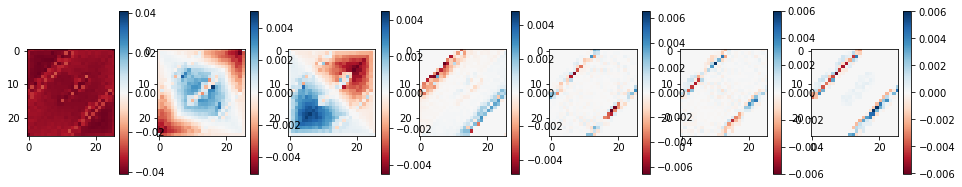

module output:


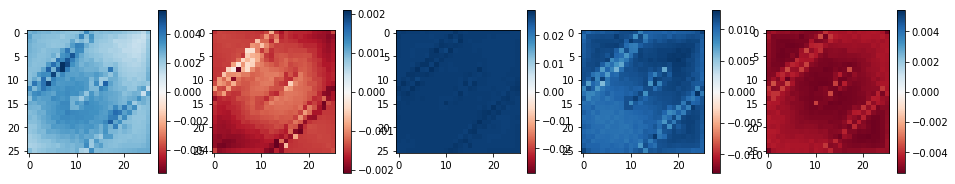

_feature 13 ReLU()


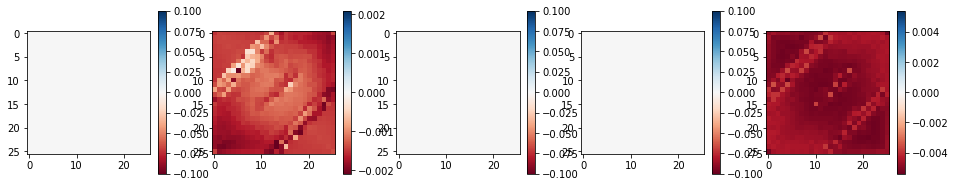

_feature 14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


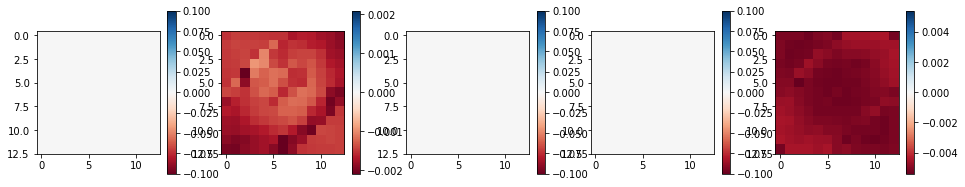

_feature 15 TaylorConv2d(
  (conv2d): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


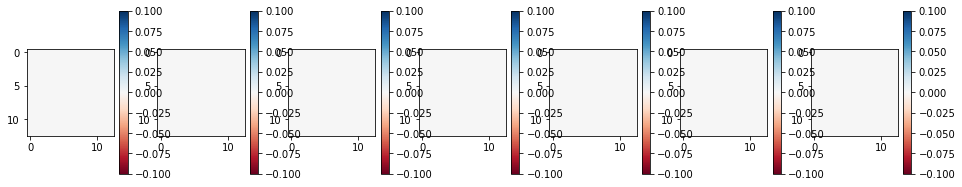

module output:


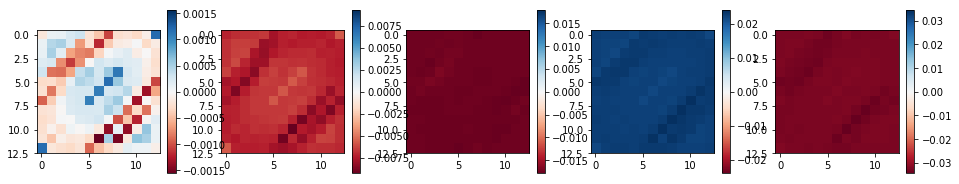

_feature 16 ReLU()


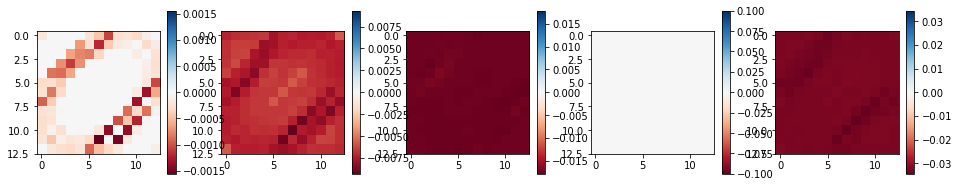

_feature 17 TaylorConv2d(
  (conv2d): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


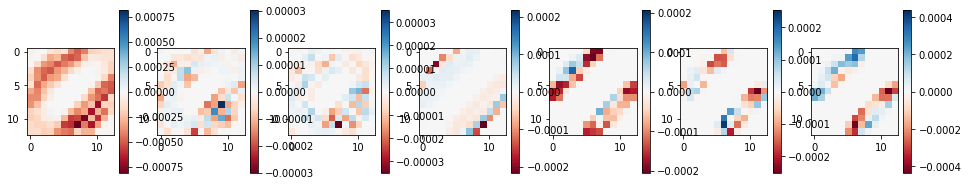

module output:


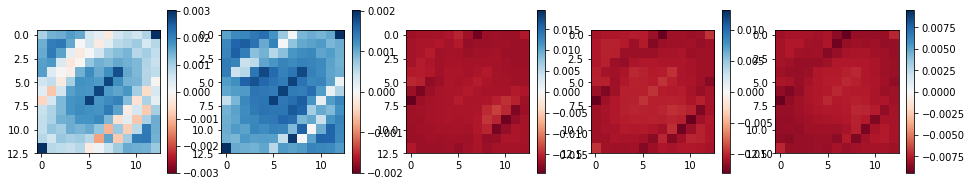

_feature 18 ReLU()


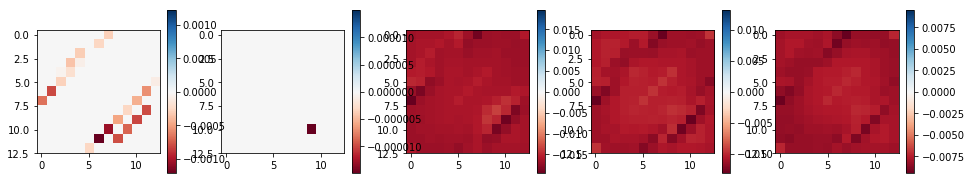

_feature 19 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


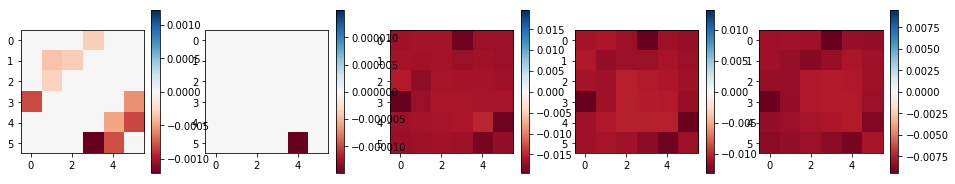

_feature 20 TaylorConv2d(
  (conv2d): Conv2d(896, 256, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


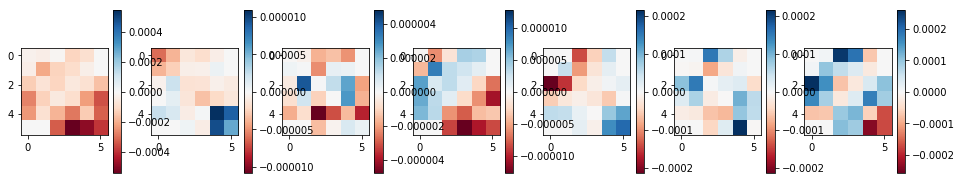

module output:


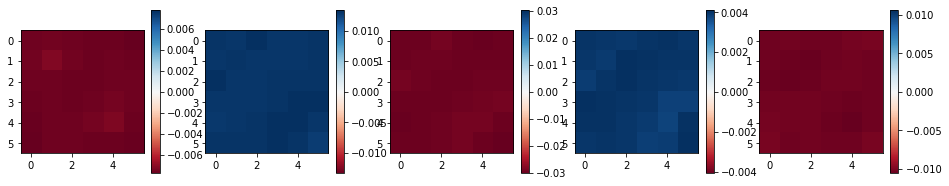

_feature 21 ReLU()


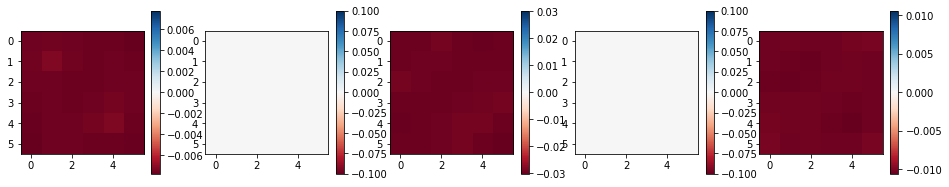

_feature 22 TaylorConv2d(
  (conv2d): Conv2d(1792, 256, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


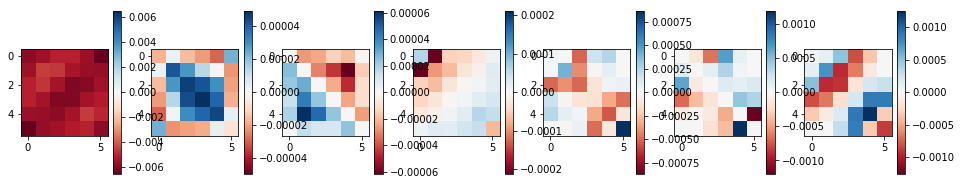

module output:


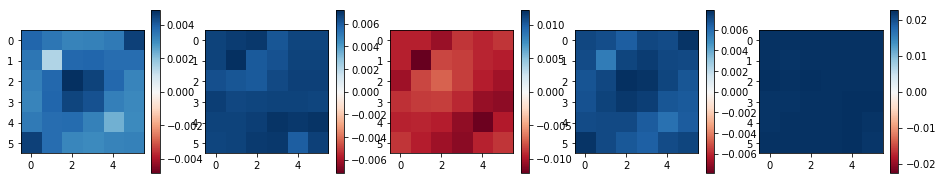

_feature 23 ReLU()


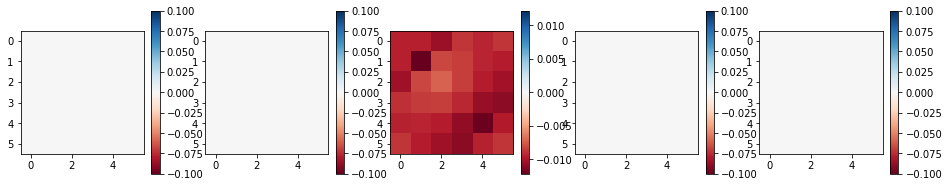

torch.Size([200, 256, 6, 6]) after _feature
torch.Size([200, 256, 1, 1]) after AvgPool2d
torch.Size([200, 256]) after view


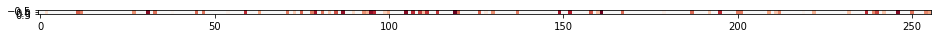

_classifier 0 Linear(in_features=256, out_features=32, bias=True)


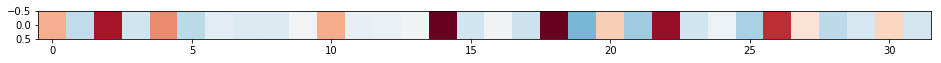

_classifier 1 ReLU()


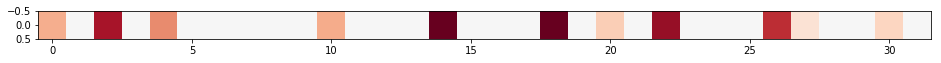

_classifier 2 Linear(in_features=32, out_features=3, bias=True)


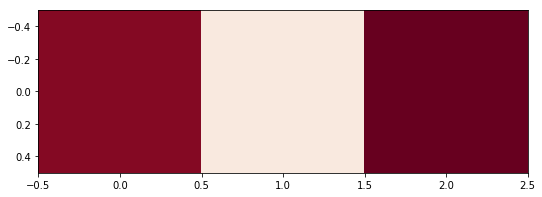

In [122]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        
        if hasattr(module, 'taylor'):
            print('taylor inputs:')
            tx = module.taylor(x)
            fig, axes = plt.subplots(1, 7, figsize=(16,3),facecolor='w')
            for i in range(7):
                im = imshowRdBu(axes[i], tx[ev,i*x.shape[1],:,:].cpu())
                cbar = axes[i].figure.colorbar(im, ax=axes[i])
            plt.show()
            print('module output:')
        
        x = module(x)
        fig, axes = plt.subplots(1, 5, figsize=(16,3),facecolor='w')
        for i in range(5):
            im = imshowRdBu(axes[i], x[ev,i,:,:].cpu())
            cbar = axes[i].figure.colorbar(im, ax=axes[i])
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,256)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()

## Further scale coordinates for more uniform values

also use lambda=0.1

In [124]:
mGridPmt = f['mGridPmt'][()]
mGridCoord = np.stack([
    f['mGridX'][()]/60.,
    f['mGridY'][()]/60.,
    f['mGridZ'][()]/60.,
    f['mGridDirX'][()]*10.,
    f['mGridDirY'][()]*10.,
    f['mGridDirZ'][()]*10.
])

taylor0 = Taylorizer(mGridPmt, mGridCoord, pad=1, Lambda=0.1)

starting inversion... (may take a few seconds)
done


0


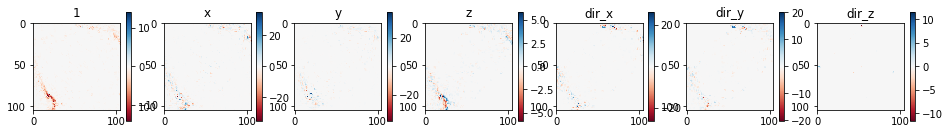

1


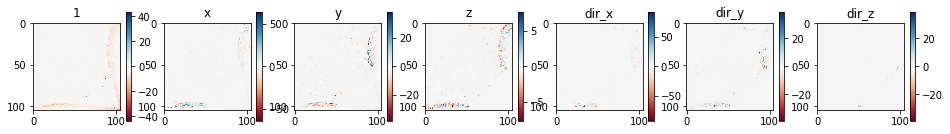

In [127]:
tayloredInput = taylor0(inputs)

for ev in range(tayloredInput.shape[0]):
    print(ev)
    taylorTitles = ['1','x','y','z','dir_x','dir_y','dir_z']
    fig, axes = plt.subplots(1, taylor0.Ntaylor, figsize=(16,2),facecolor='w')
    for itaylor in range(taylor0.Ntaylor):
        im = imshowRdBu(axes[itaylor], tayloredInput[ev,itaylor,:,:])
        axes[itaylor].set_title(taylorTitles[itaylor])
        cbar = axes[itaylor].figure.colorbar(im, ax=axes[itaylor])
    plt.show()

In [128]:
class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3, taylor0).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


In [129]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-19 07:54:35


Epoch 1 Starting @ 2019-08-19 07:57:14


Epoch 2 Starting @ 2019-08-19 07:59:52


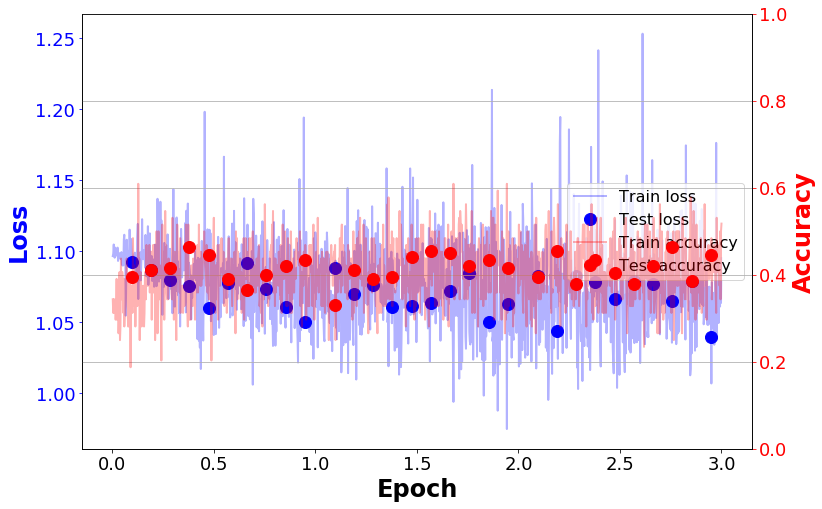

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

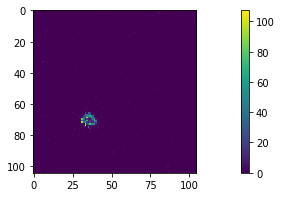

_feature 0 TaylorConv2d(
  (conv2d): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


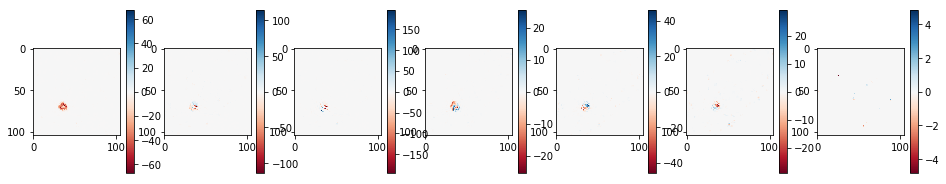

module output:


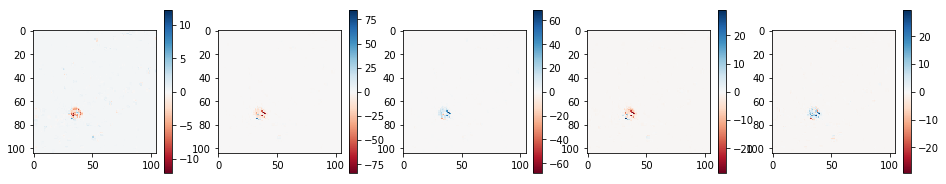

_feature 1 ReLU()


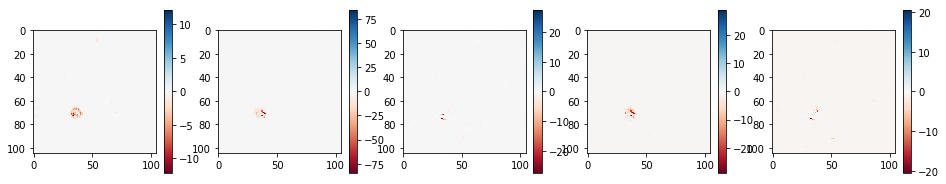

_feature 2 TaylorConv2d(
  (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


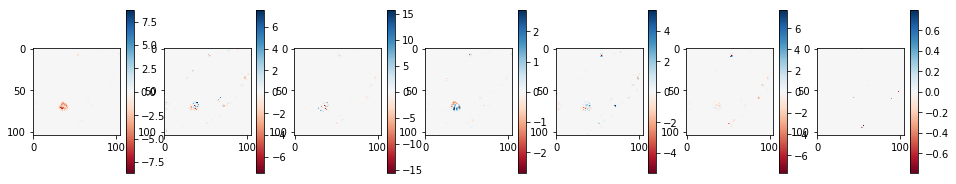

module output:


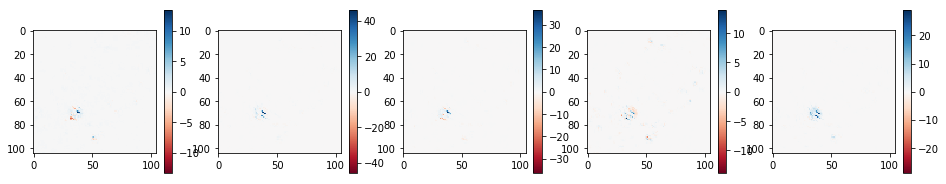

_feature 3 ReLU()


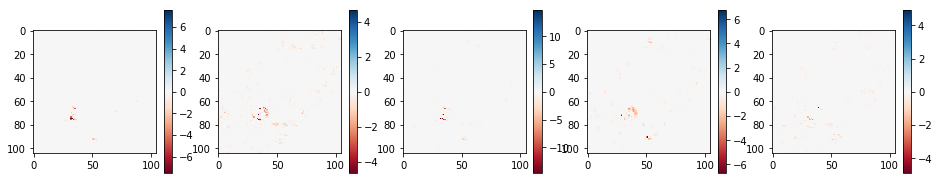

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


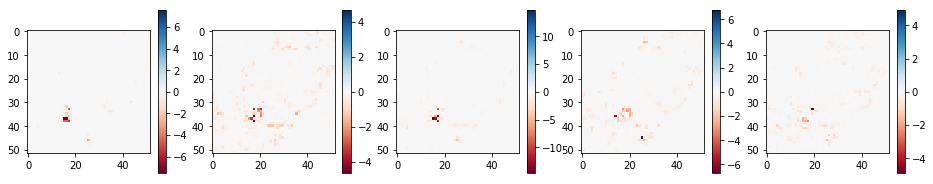

_feature 5 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


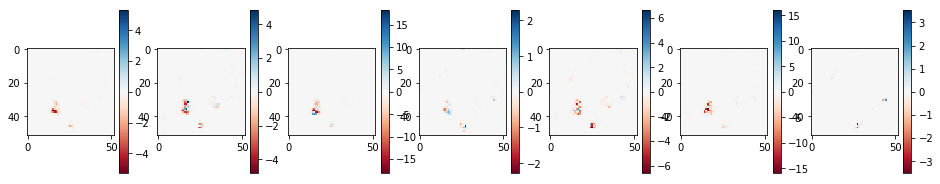

module output:


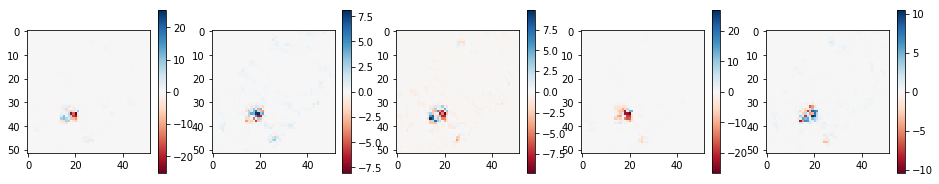

_feature 6 ReLU()


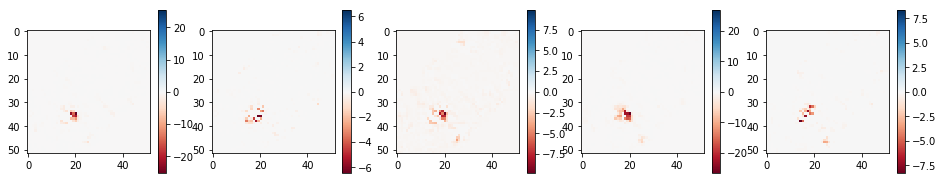

_feature 7 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


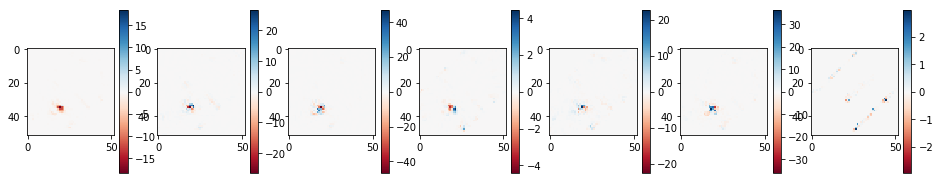

module output:


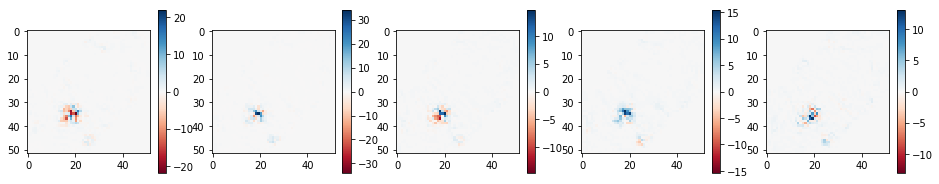

_feature 8 ReLU()


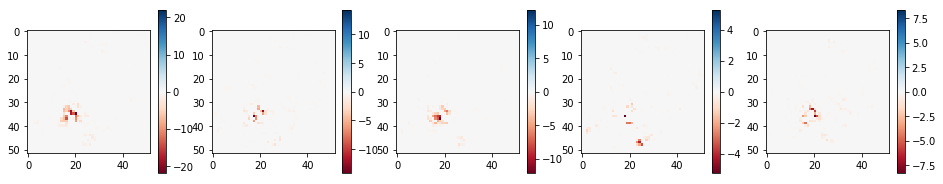

_feature 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


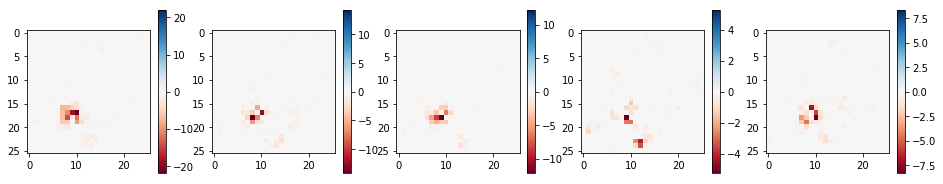

_feature 10 TaylorConv2d(
  (conv2d): Conv2d(224, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


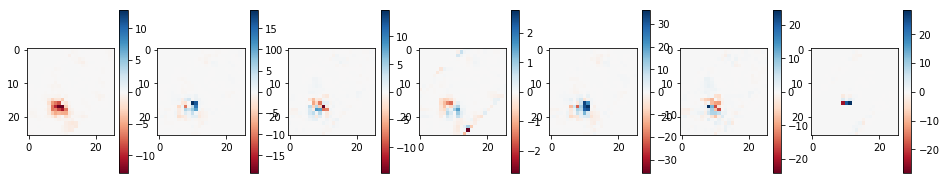

module output:


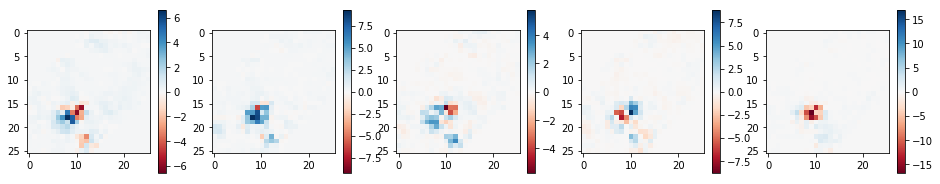

_feature 11 ReLU()


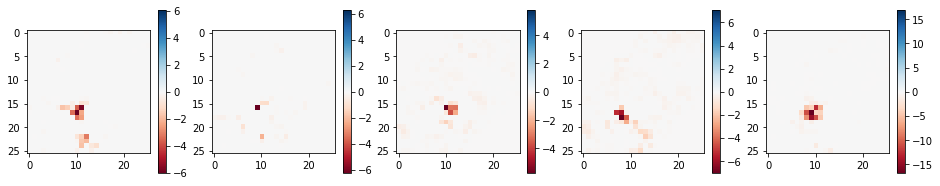

_feature 12 TaylorConv2d(
  (conv2d): Conv2d(448, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


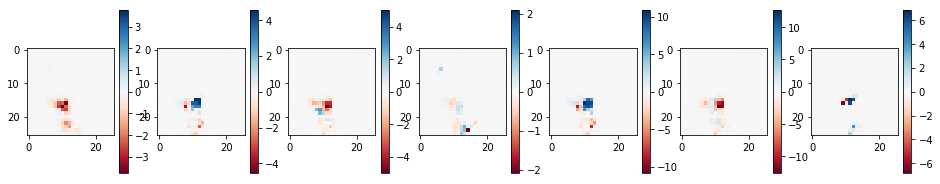

module output:


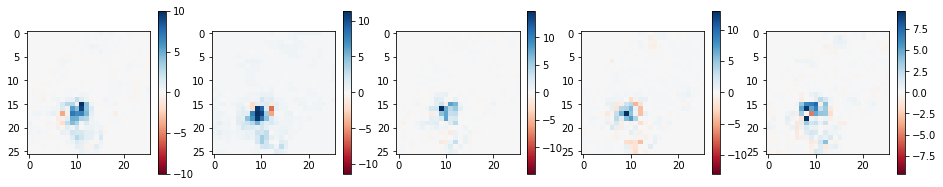

_feature 13 ReLU()


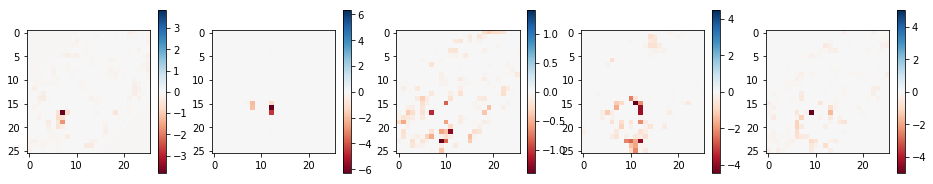

_feature 14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


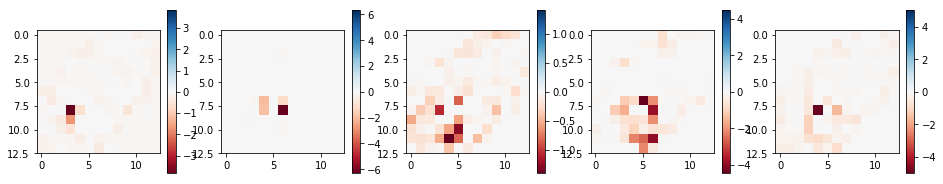

_feature 15 TaylorConv2d(
  (conv2d): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


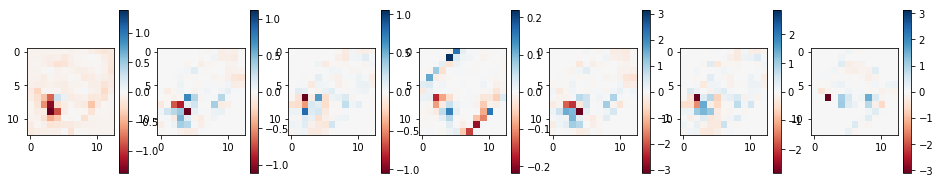

module output:


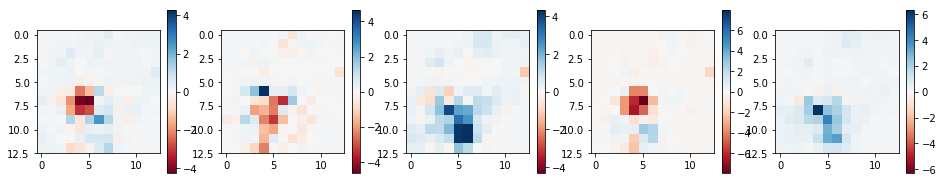

_feature 16 ReLU()


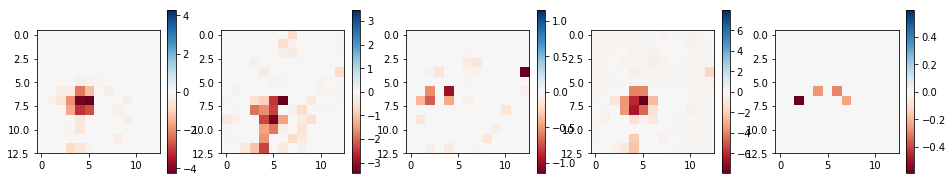

_feature 17 TaylorConv2d(
  (conv2d): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


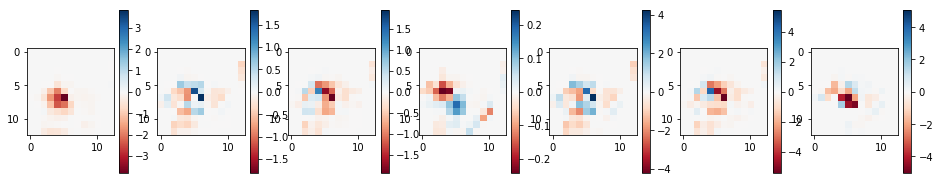

module output:


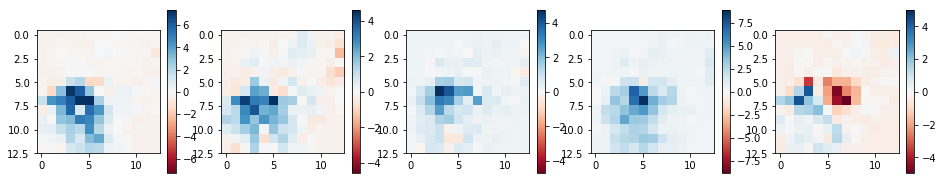

_feature 18 ReLU()


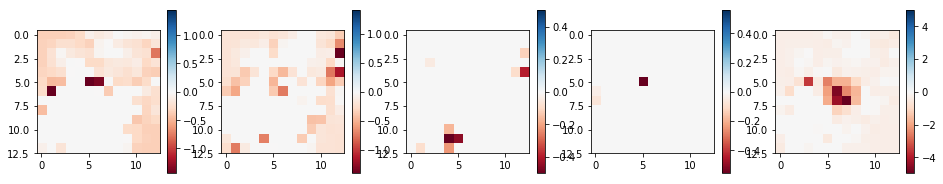

_feature 19 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


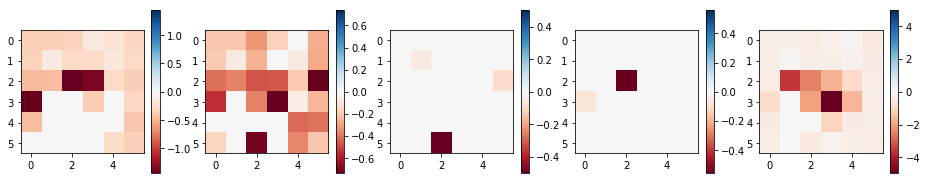

_feature 20 TaylorConv2d(
  (conv2d): Conv2d(896, 256, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


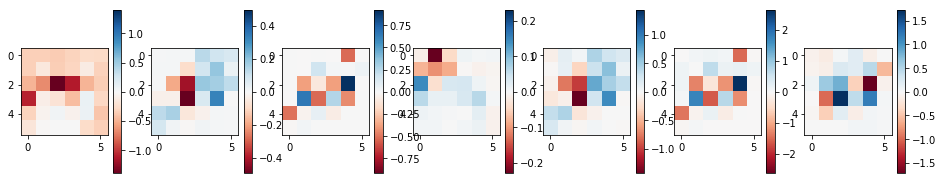

module output:


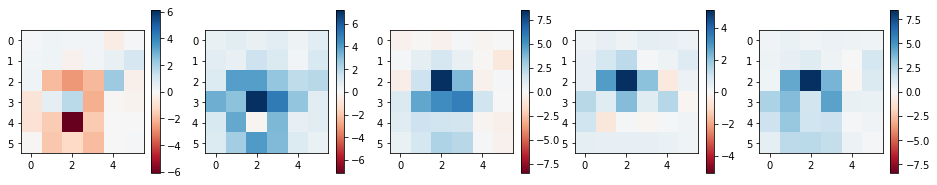

_feature 21 ReLU()


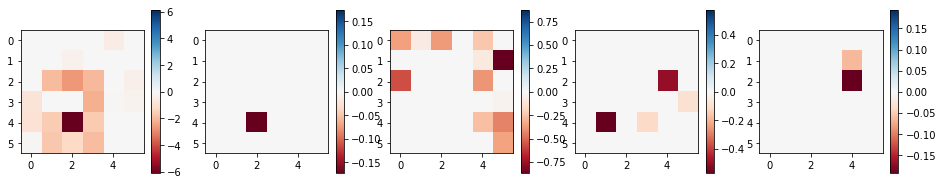

_feature 22 TaylorConv2d(
  (conv2d): Conv2d(1792, 256, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


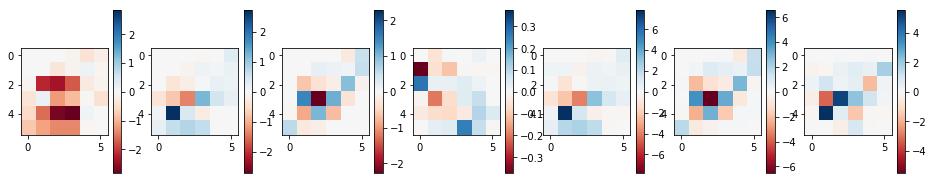

module output:


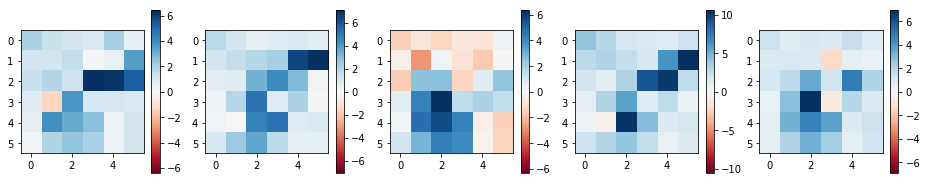

_feature 23 ReLU()


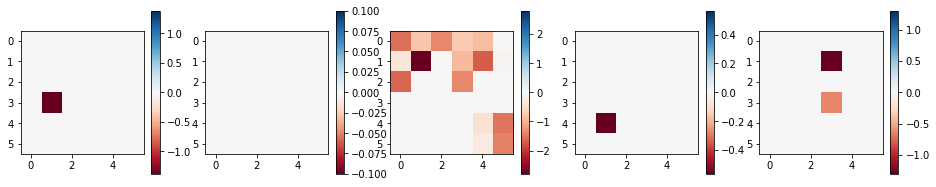

torch.Size([200, 256, 6, 6]) after _feature
torch.Size([200, 256, 1, 1]) after AvgPool2d
torch.Size([200, 256]) after view


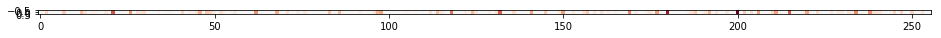

_classifier 0 Linear(in_features=256, out_features=32, bias=True)


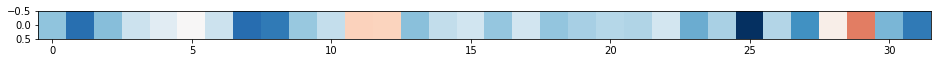

_classifier 1 ReLU()


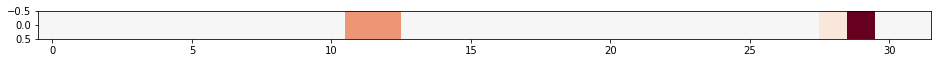

_classifier 2 Linear(in_features=32, out_features=3, bias=True)


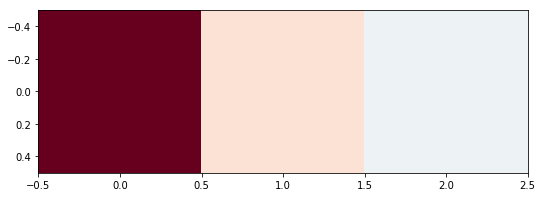

In [131]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        
        if hasattr(module, 'taylor'):
            print('taylor inputs:')
            tx = module.taylor(x)
            fig, axes = plt.subplots(1, 7, figsize=(16,3),facecolor='w')
            for i in range(7):
                im = imshowRdBu(axes[i], tx[ev,i*x.shape[1],:,:].cpu())
                cbar = axes[i].figure.colorbar(im, ax=axes[i])
            plt.show()
            print('module output:')
        
        x = module(x)
        fig, axes = plt.subplots(1, 5, figsize=(16,3),facecolor='w')
        for i in range(5):
            im = imshowRdBu(axes[i], x[ev,i,:,:].cpu())
            cbar = axes[i].figure.colorbar(im, ax=axes[i])
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,256)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()

## BatchNorm

In [137]:
class GeomConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(GeomConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.pad = pad
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*self.pad+1)
 
    def forward(self, x):
        inputsPad = geometricPad(x, self.pad); # (B,C,W,H)
        return self.conv2d(inputsPad)

class TaylorConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super(TaylorConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        return self.conv2d(self.taylor(x))
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorConv2d, self).cuda()
        self.taylor.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class, taylor):
        super(TaylorCNN, self).__init__()
        
        # prepare taylorizers for maxpool operations
        taylor1 = taylor .pool2d((2,2))
        taylor2 = taylor1.pool2d((2,2))
        #taylor3 = taylor2.pool2d((2,2))
        #taylor4 = taylor3.pool2d((2,2))
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # taylor conv
            TaylorConv2d( 1,16,taylor), torch.nn.ReLU(), torch.nn.BatchNorm2d(16),
            TaylorConv2d(16,32,taylor), torch.nn.ReLU(), torch.nn.BatchNorm2d(32),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(32,32,taylor1), torch.nn.ReLU(), torch.nn.BatchNorm2d(32),
            TaylorConv2d(32,32,taylor1), torch.nn.ReLU(), torch.nn.BatchNorm2d(32),
            
            torch.nn.MaxPool2d(2,2),
            TaylorConv2d(32,64,taylor2), torch.nn.ReLU(), torch.nn.BatchNorm2d(64),
            TaylorConv2d(64,64,taylor2), torch.nn.ReLU(), torch.nn.BatchNorm2d(64),
            
            torch.nn.MaxPool2d(2,2),
            GeomConv2d( 64,128,1), torch.nn.ReLU(), torch.nn.BatchNorm2d(128),
            GeomConv2d(128,128,1), torch.nn.ReLU(), torch.nn.BatchNorm2d(128)
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,32), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [138]:
class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3, taylor0).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


In [139]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-19 08:11:01


Epoch 1 Starting @ 2019-08-19 08:13:29


Epoch 2 Starting @ 2019-08-19 08:15:57


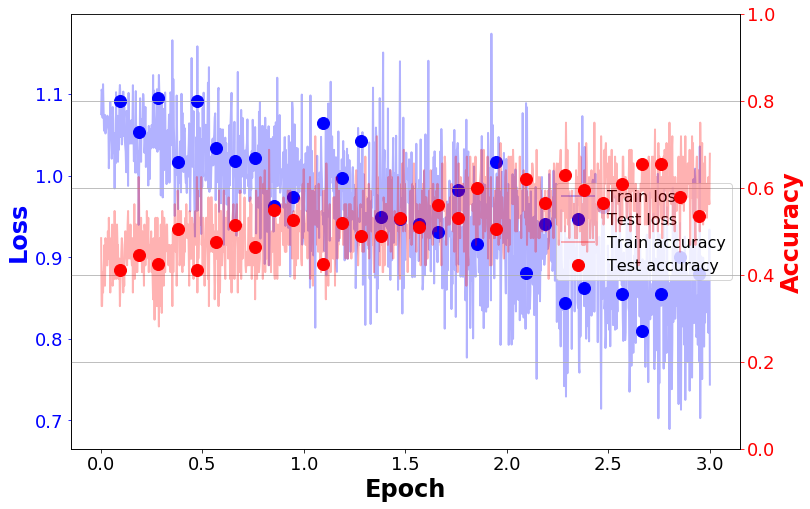

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

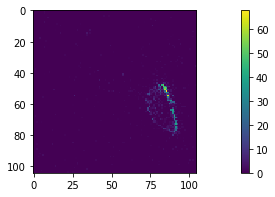

_feature 0 TaylorConv2d(
  (conv2d): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


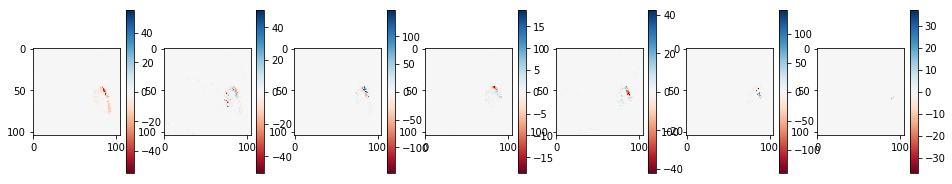

module output:


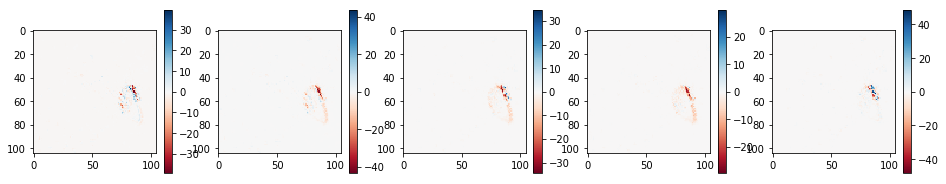

_feature 1 ReLU()


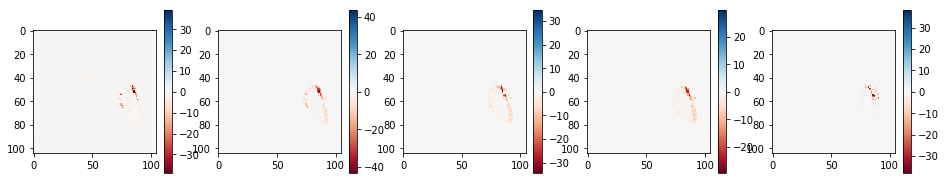

_feature 2 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


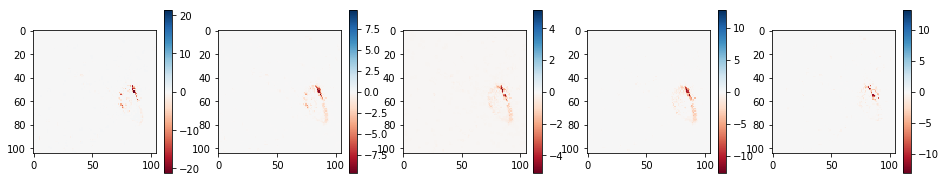

_feature 3 TaylorConv2d(
  (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


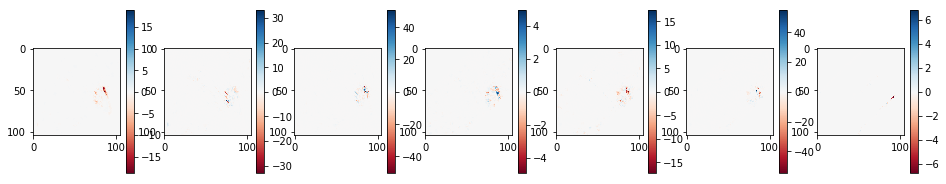

module output:


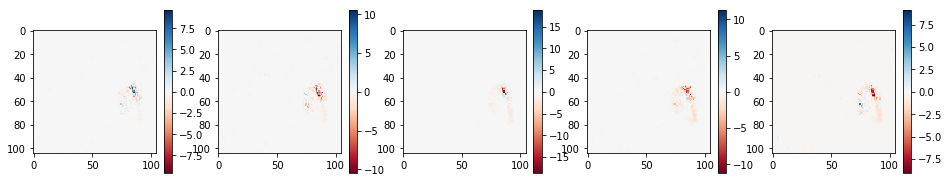

_feature 4 ReLU()


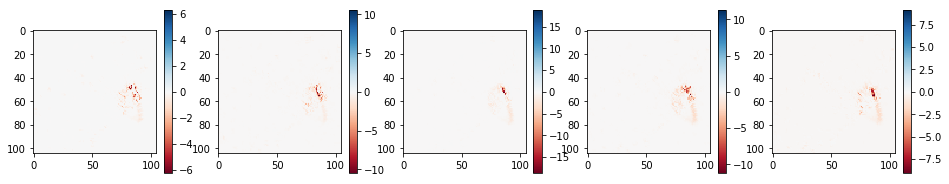

_feature 5 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


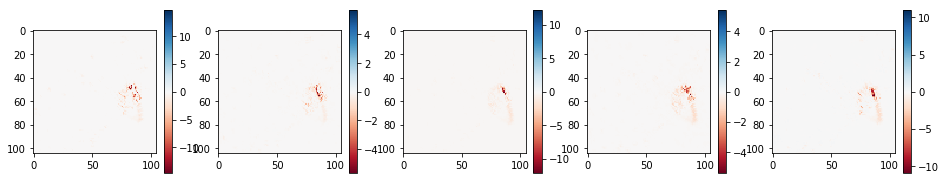

_feature 6 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


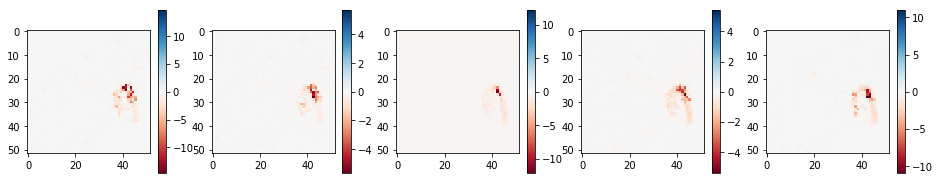

_feature 7 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


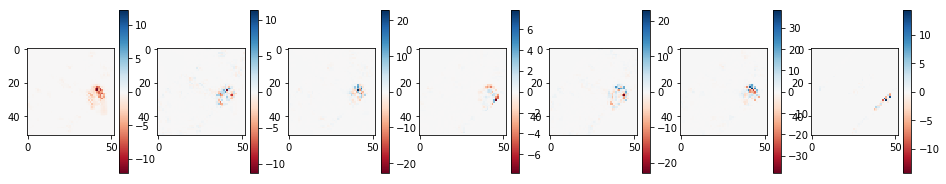

module output:


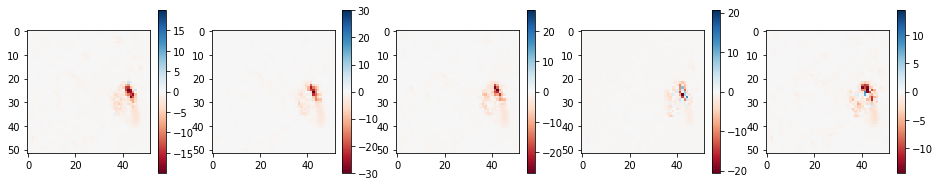

_feature 8 ReLU()


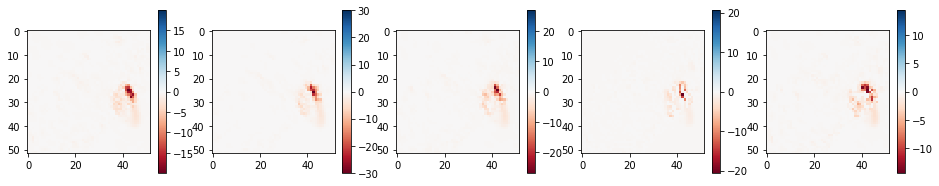

_feature 9 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


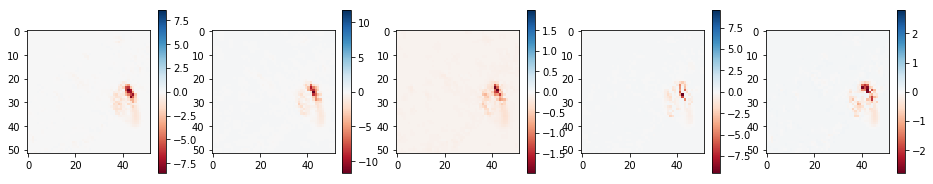

_feature 10 TaylorConv2d(
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


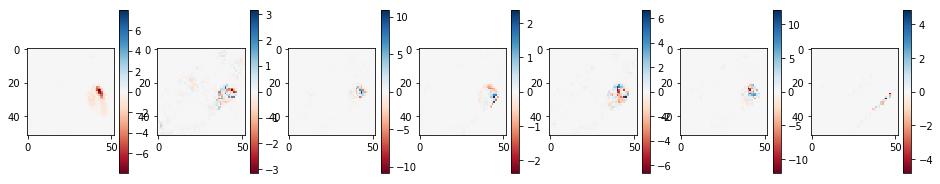

module output:


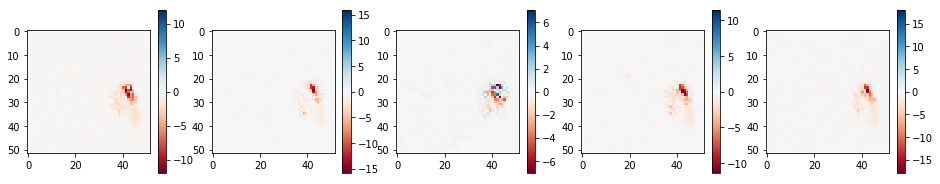

_feature 11 ReLU()


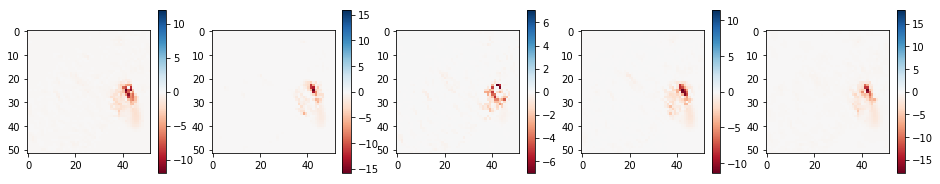

_feature 12 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


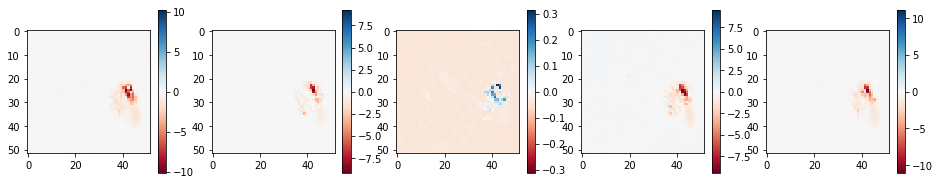

_feature 13 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


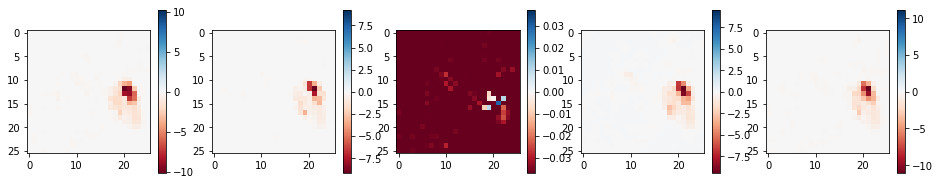

_feature 14 TaylorConv2d(
  (conv2d): Conv2d(224, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


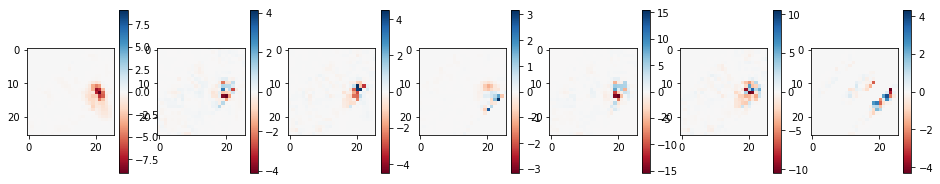

module output:


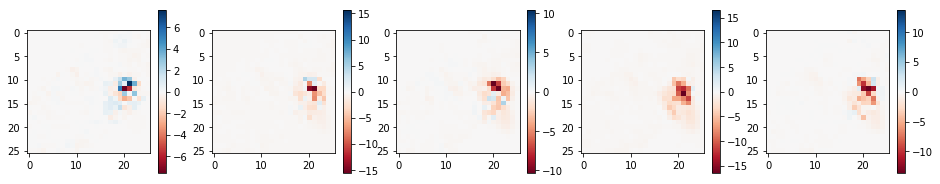

_feature 15 ReLU()


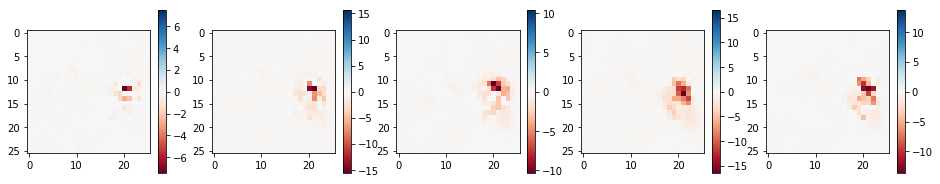

_feature 16 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


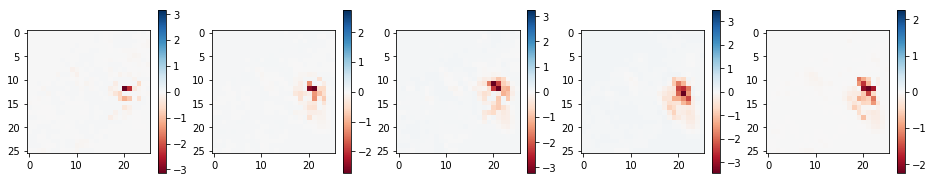

_feature 17 TaylorConv2d(
  (conv2d): Conv2d(448, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


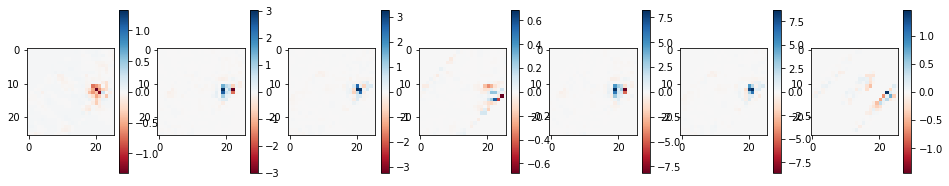

module output:


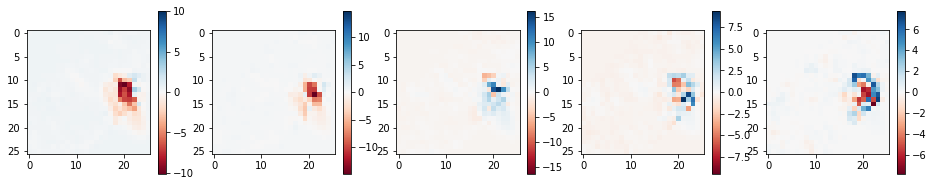

_feature 18 ReLU()


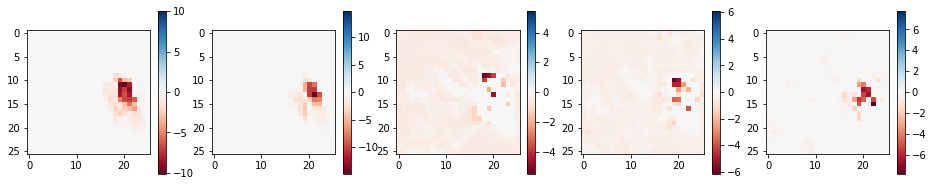

_feature 19 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


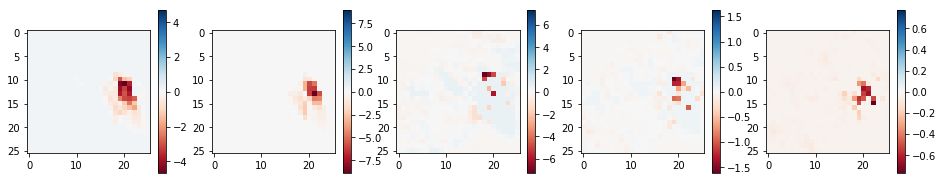

_feature 20 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


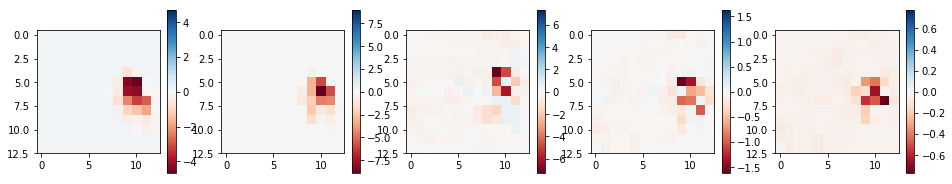

_feature 21 GeomConv2d(
  (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
)


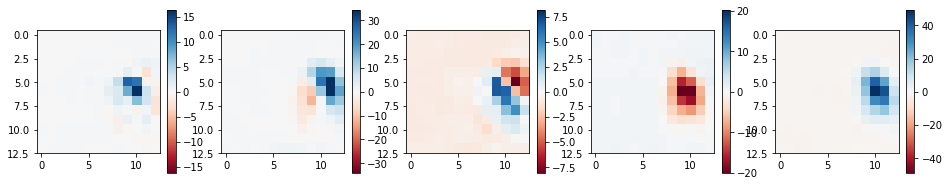

_feature 22 ReLU()


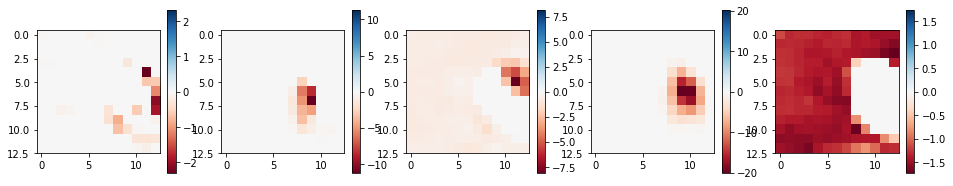

_feature 23 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


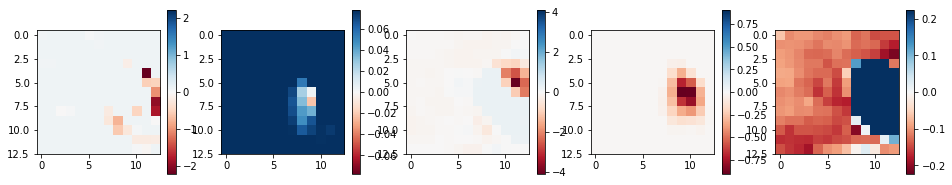

_feature 24 GeomConv2d(
  (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
)


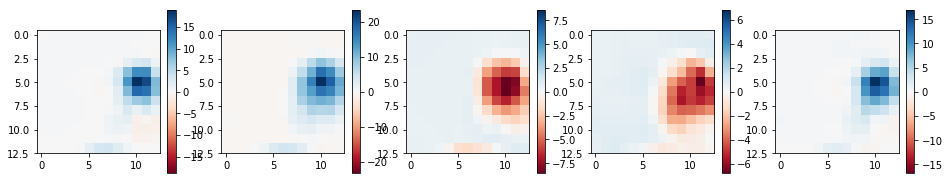

_feature 25 ReLU()


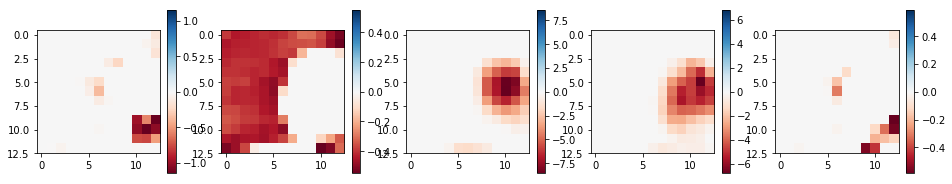

_feature 26 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


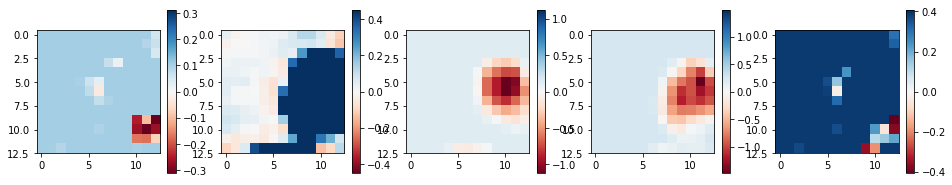

torch.Size([200, 128, 13, 13]) after _feature
torch.Size([200, 128, 1, 1]) after AvgPool2d
torch.Size([200, 128]) after view


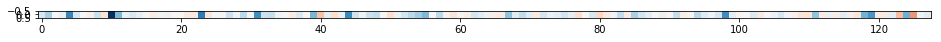

_classifier 0 Linear(in_features=128, out_features=32, bias=True)


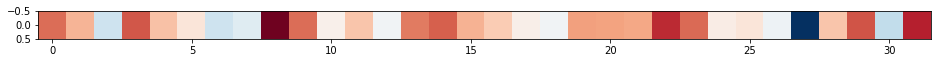

_classifier 1 ReLU()


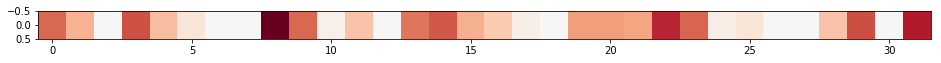

_classifier 2 Linear(in_features=32, out_features=3, bias=True)


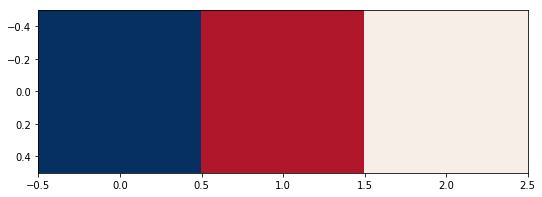

In [142]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        
        if hasattr(module, 'taylor'):
            print('taylor inputs:')
            tx = module.taylor(x)
            fig, axes = plt.subplots(1, 7, figsize=(16,3),facecolor='w')
            for i in range(7):
                im = imshowRdBu(axes[i], tx[ev,i*x.shape[1],:,:].cpu())
                cbar = axes[i].figure.colorbar(im, ax=axes[i])
            plt.show()
            print('module output:')
        
        x = module(x)
        fig, axes = plt.subplots(1, 5, figsize=(16,3),facecolor='w')
        for i in range(5):
            im = imshowRdBu(axes[i], x[ev,i,:,:].cpu())
            cbar = axes[i].figure.colorbar(im, ax=axes[i])
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,128)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()

In [147]:
blob.iteration = iteration

def save_state(blob, prefix='./snapshot'):
    # Output file name
    filename = '%s-%d.ckpt' % (prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(weight_file, blob):
    # Open a file in read-binary mode
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.iteration = checkpoint['global_step']

weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

Saved to 20190819-02-DeepTaylor-01-BatchNorm-1266.ckpt


In [144]:
with open(weight_file, 'rb') as f:
    # torch interprets the file, then we can access using string keys
    checkpoint = torch.load(f)

## BatchNorm in taylorizing layer

In [151]:
class GeomConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(GeomConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.pad = pad
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*self.pad+1)
 
    def forward(self, x):
        inputsPad = geometricPad(x, self.pad); # (B,C,W,H)
        return self.conv2d(inputsPad)

class TaylorBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super(TaylorBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin*taylor.Ntaylor)
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        x = self.taylor(x)
        x = self.batchNorm2d(x)
        x = self.conv2d(x)
        return x
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorBNConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorBNConv2d, self).cuda()
        self.taylor.cuda()
        return self


class TaylorCNN(torch.nn.Module):
    
    def __init__(self, num_class, taylor):
        super(TaylorCNN, self).__init__()
        
        # prepare taylorizers for maxpool operations
        taylor1 = taylor .pool2d((2,2))
        taylor2 = taylor1.pool2d((2,2))
        #taylor3 = taylor2.pool2d((2,2))
        #taylor4 = taylor3.pool2d((2,2))
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            # taylor conv
            TaylorBNConv2d( 1,16,taylor), torch.nn.ReLU(),
            TaylorBNConv2d(16,32,taylor), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorBNConv2d(32,32,taylor1), torch.nn.ReLU(),
            TaylorBNConv2d(32,32,taylor1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            TaylorBNConv2d(32,64,taylor2), torch.nn.ReLU(),
            TaylorBNConv2d(64,64,taylor2), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            torch.nn.BatchNorm2d(64),
            GeomConv2d( 64,128,1), torch.nn.ReLU(), torch.nn.BatchNorm2d(128),
            GeomConv2d(128,128,1), torch.nn.ReLU(), torch.nn.BatchNorm2d(128)
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,32), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(TaylorCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(TaylorCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [152]:
class BLOB:
    pass
blob=BLOB()
blob.net       = TaylorCNN(3, taylor0).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

starting inversion... (may take a few seconds)
done
starting inversion... (may take a few seconds)
done


In [153]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2019-08-19 08:41:44


Epoch 1 Starting @ 2019-08-19 08:44:17


Epoch 2 Starting @ 2019-08-19 08:46:51


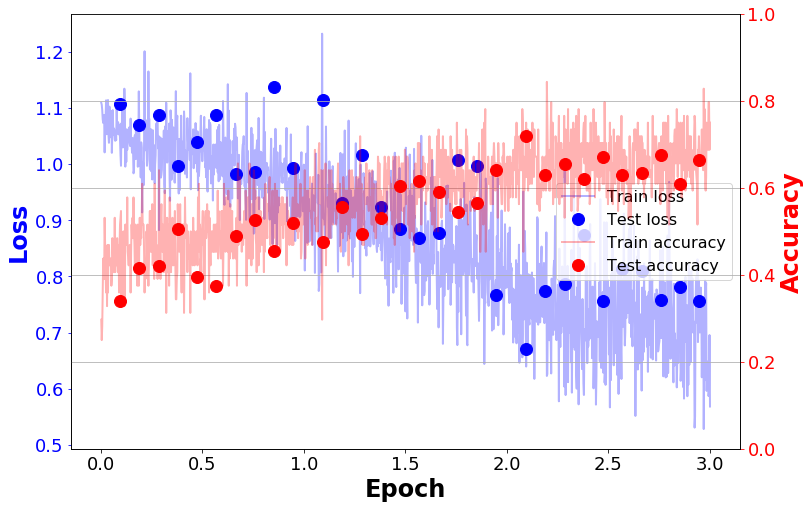

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [155]:
blob.iteration = iteration
weight_file = save_state(blob, '20190819-02-DeepTaylor-02-TaylorBN')
print('Saved to', weight_file)

Saved to 20190819-02-DeepTaylor-02-TaylorBN-1266.ckpt


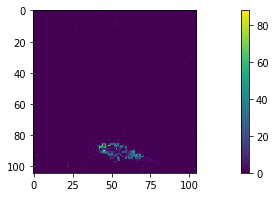

_feature 0 TaylorBNConv2d(
  (batchNorm2d): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(7, 16, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


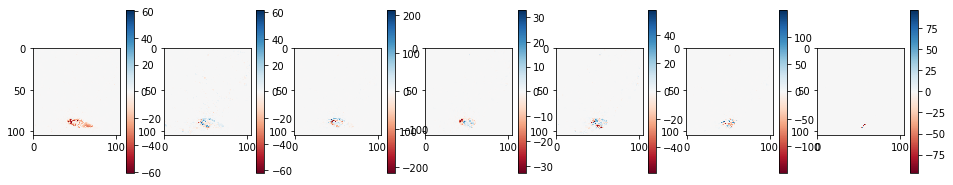

module output:


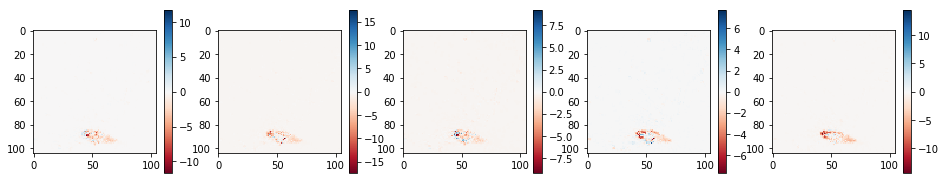

_feature 1 ReLU()


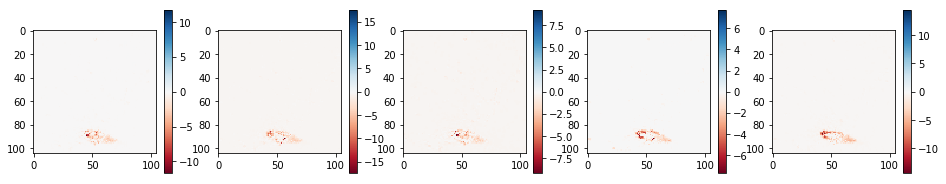

_feature 2 TaylorBNConv2d(
  (batchNorm2d): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


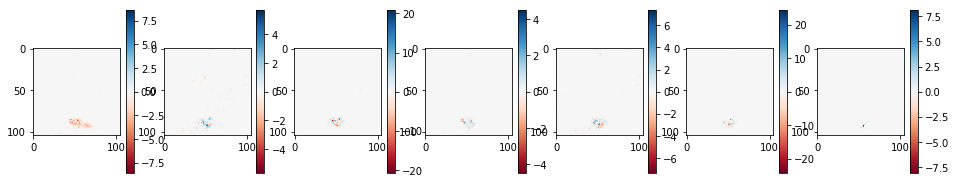

module output:


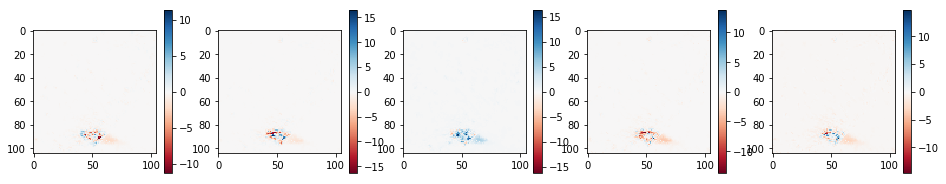

_feature 3 ReLU()


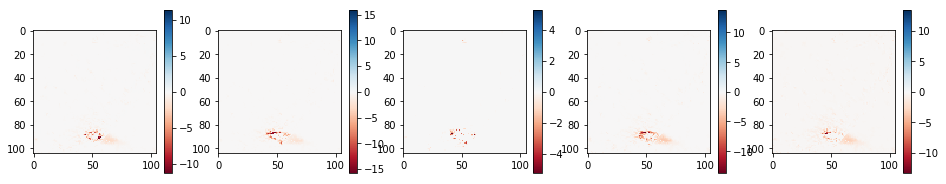

_feature 4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


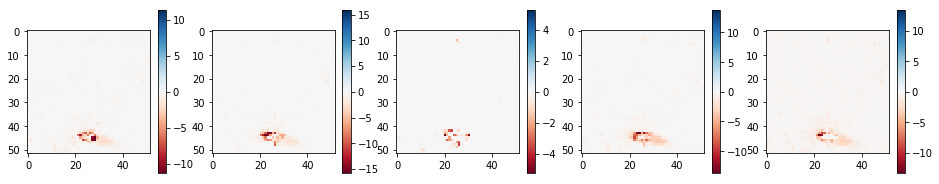

_feature 5 TaylorBNConv2d(
  (batchNorm2d): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


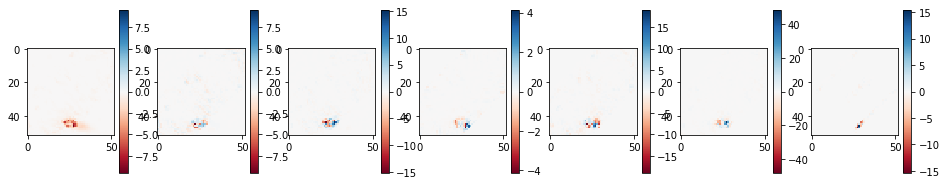

module output:


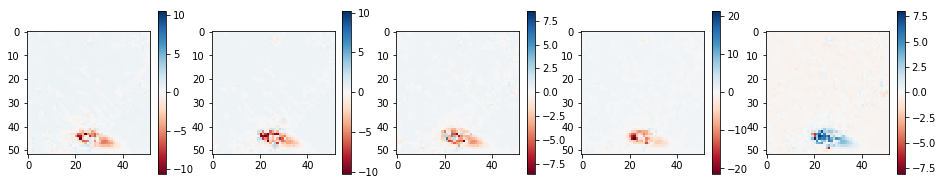

_feature 6 ReLU()


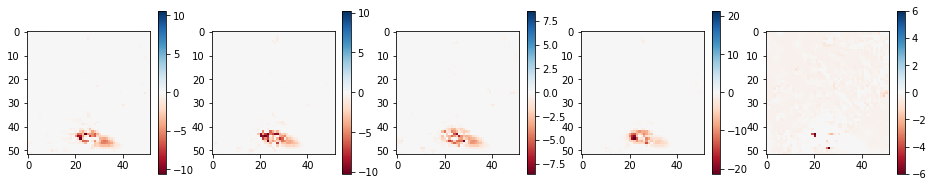

_feature 7 TaylorBNConv2d(
  (batchNorm2d): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(224, 32, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


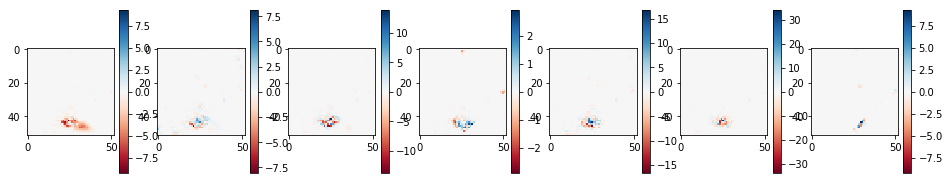

module output:


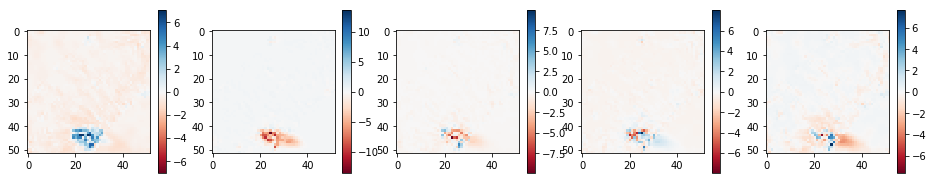

_feature 8 ReLU()


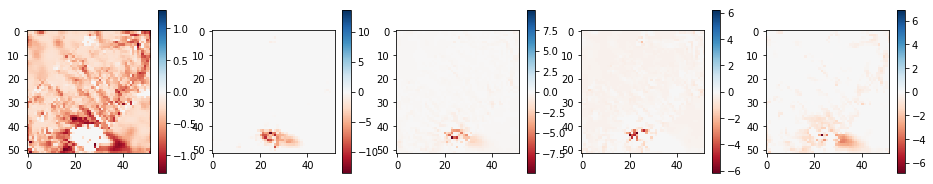

_feature 9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


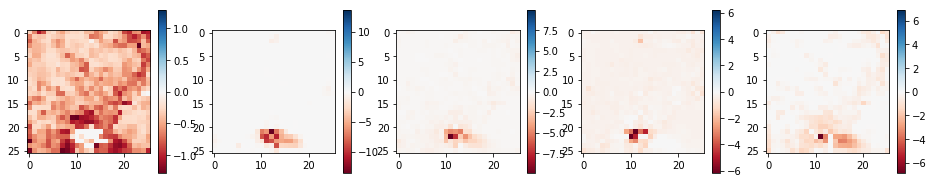

_feature 10 TaylorBNConv2d(
  (batchNorm2d): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(224, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


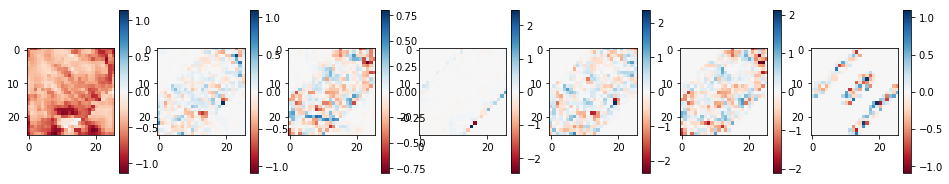

module output:


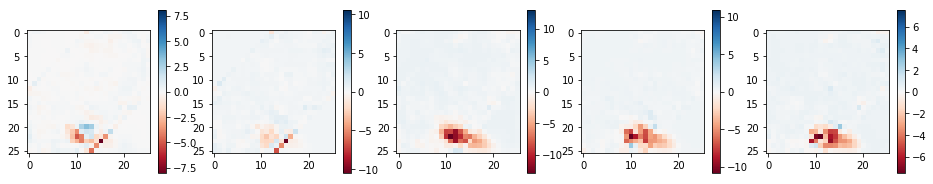

_feature 11 ReLU()


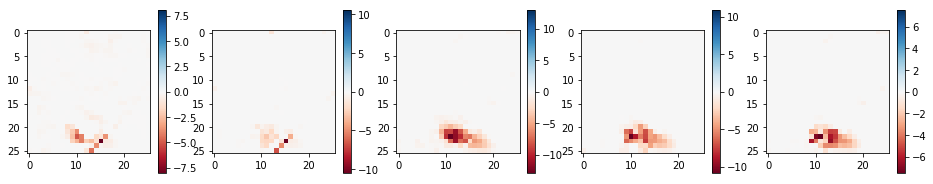

_feature 12 TaylorBNConv2d(
  (batchNorm2d): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d): Conv2d(448, 64, kernel_size=(1, 1), stride=(1, 1))
)
taylor inputs:


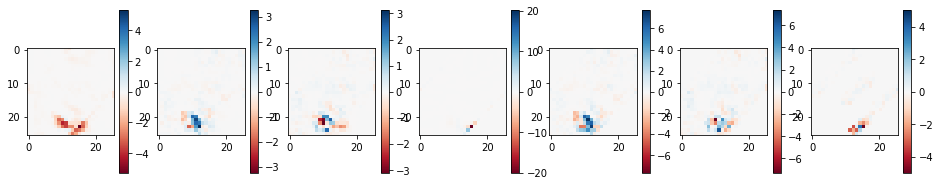

module output:


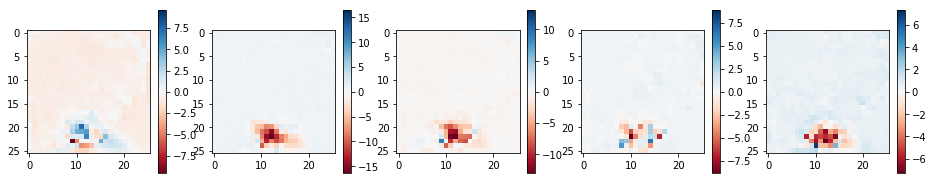

_feature 13 ReLU()


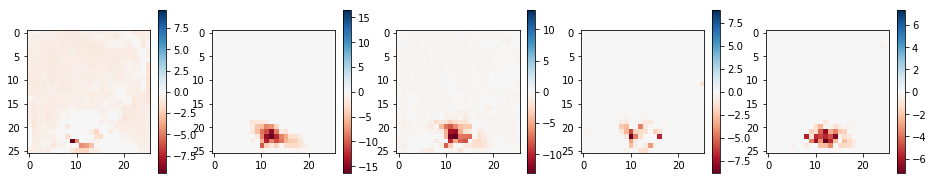

_feature 14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


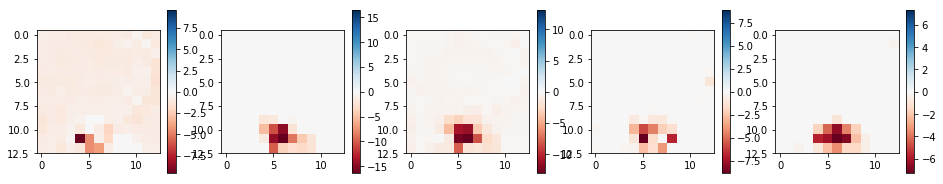

_feature 15 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


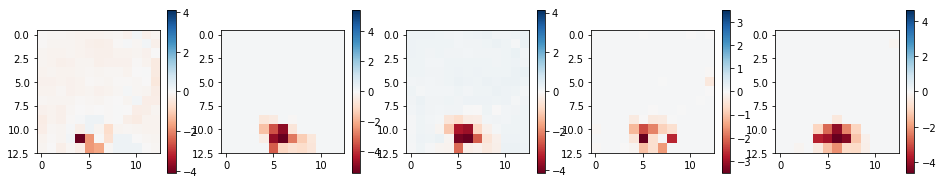

_feature 16 GeomConv2d(
  (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
)


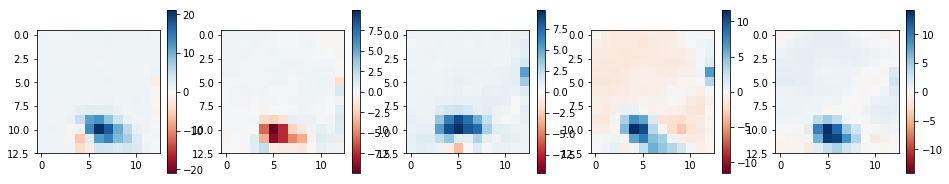

_feature 17 ReLU()


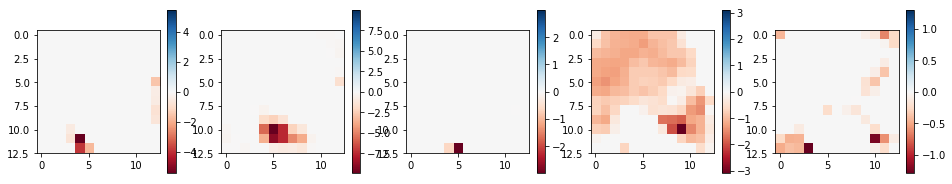

_feature 18 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


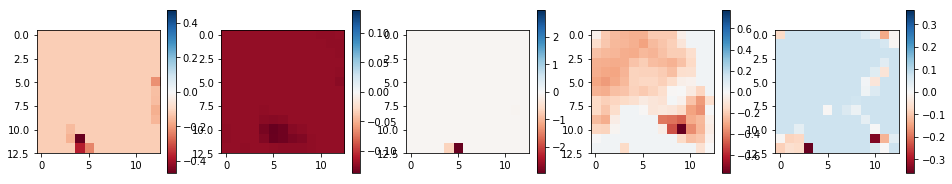

_feature 19 GeomConv2d(
  (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
)


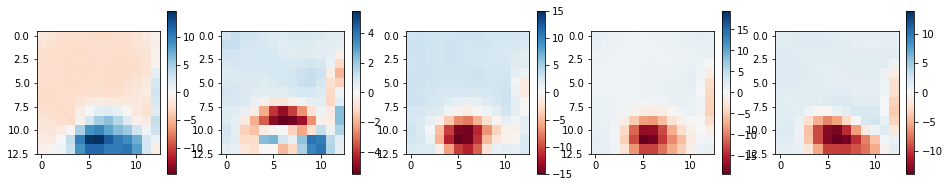

_feature 20 ReLU()


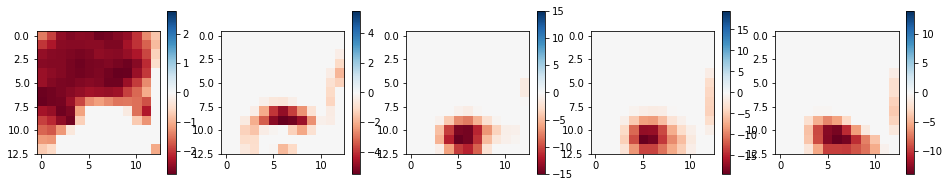

_feature 21 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


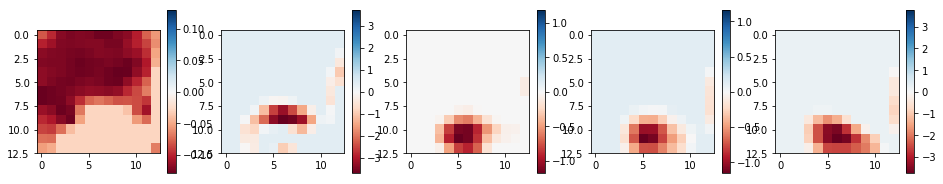

torch.Size([200, 128, 13, 13]) after _feature
torch.Size([200, 128, 1, 1]) after AvgPool2d
torch.Size([200, 128]) after view


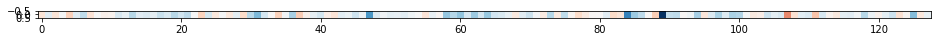

_classifier 0 Linear(in_features=128, out_features=32, bias=True)


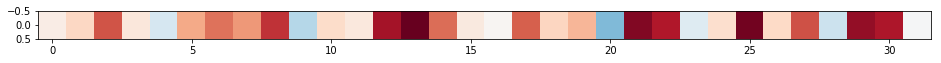

_classifier 1 ReLU()


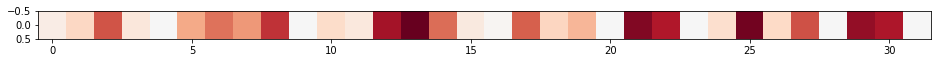

_classifier 2 Linear(in_features=32, out_features=3, bias=True)


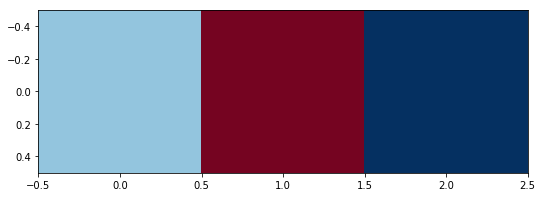

In [157]:
with torch.no_grad():
    blob.net.eval()
    test_data = next(iter(test_loader))
    blob.data,blob.label = test_data[0:2]
    
    data = torch.as_tensor(blob.data).cuda()
    data = data.permute(0,3,1,2)
    # prediction = blob.net(data)
    
    ev=1
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    im = ax0.imshow(data[ev,0,:,:].cpu())
    cbar = ax0.figure.colorbar(im, ax=ax0)
    plt.show()
    
    x = data
    for i,module in enumerate(blob.net._feature):
        print('_feature', i, module)
        
        if hasattr(module, 'taylor'):
            print('taylor inputs:')
            tx = module.taylor(x)
            fig, axes = plt.subplots(1, 7, figsize=(16,3),facecolor='w')
            for i in range(7):
                im = imshowRdBu(axes[i], tx[ev,i*x.shape[1],:,:].cpu())
                cbar = axes[i].figure.colorbar(im, ax=axes[i])
            plt.show()
            print('module output:')
        
        x = module(x)
        fig, axes = plt.subplots(1, 5, figsize=(16,3),facecolor='w')
        for i in range(5):
            im = imshowRdBu(axes[i], x[ev,i,:,:].cpu())
            cbar = axes[i].figure.colorbar(im, ax=axes[i])
        plt.show()
    
    # next the classifier
    print(x.shape, 'after _feature')
    x = torch.nn.AvgPool2d(x.size()[2:])(x)
    print(x.shape, 'after AvgPool2d')
    x = x.view(-1,128)
    print(x.shape, 'after view')
    
    fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
    imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
    plt.show()
    
    for i,module in enumerate(blob.net._classifier):
        print('_classifier', i, module)
        x = module(x)
        fig, (ax0) = plt.subplots(1, 1, figsize=(16,3),facecolor='w')
        imshowRdBu(ax0, x[ev,:].unsqueeze(0).cpu())
        plt.show()

In [159]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

In [160]:
from utils.utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['e','mu','pip'])

RuntimeError: CUDA out of memory. Tried to allocate 464.00 MiB (GPU 0; 11.91 GiB total capacity; 10.47 GiB already allocated; 71.31 MiB free; 710.27 MiB cached)

let's train a few more epochs

In [163]:
blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()

# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 3 Starting @ 2019-08-19 08:58:35


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 11.91 GiB total capacity; 11.00 GiB already allocated; 27.31 MiB free; 205.02 MiB cached)

In [164]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([64, 1, 105, 105])
<class 'torch.Tensor'> torch.Size([64, 16, 105, 105])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([200, 3])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 1, 105, 105])
<class 'torch.Tensor'> torch.Size([200, 32, 52, 52])
<class 'torch.Tensor'> torch.Size([200, 32, 54, 54])
<class 'torch.Tensor'> torch.Size([200, 7, 32, 52, 52])
<class 'torch.Tensor'> torch.Size([200, 32, 52, 54])
<class 'torch.Tensor'> torch.Size([200, 32, 52, 52])
<class 'torch.Tensor'> torch.Size([7, 52, 52])
<class 'torch.Tensor'> torch.Size([64, 1, 105, 105])
<class 'torch.Tensor'> torch.Size([64, 16, 105, 105])
<class 'torch.Tensor'> torch.Size([64, 16, 107, 107])
<class 'torch.Tensor'> torch.Size([64, 7, 16, 105, 105])
<class 'torch.Tensor'> torch.Size([64, 16, 105, 107])
<class 'torch.Tensor'> torch.Size([64, 16, 105, 105])
<class 'torch.Tensor'> torch.Size([7, 105, 105])


/opt/conda/lib/python3.6/site-packages/torch/distributed/distributed_c10d.py:86: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/opt/conda/lib/python3.6/importlib/__init__.py:126: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  return _bootstrap._gcd_import(name[level:], package, level)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: RangeIndex.data is deprecated and will be removed in a future version
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Index.data is deprecated and will be removed in a future version
  """
/opt/conda/lib/python3.6/site-packages/i

<class 'torch.Tensor'> torch.Size([52, 52])
<class 'torch.Tensor'> torch.Size([52, 52])
<class 'torch.Tensor'> torch.Size([52, 52])
<class 'torch.Tensor'> torch.Size([6, 52, 52])
<class 'torch.Tensor'> torch.Size([52, 52])
<class 'torch.Tensor'> torch.Size([52, 52])
<class 'torch.Tensor'> torch.Size([6, 52, 52])
<class 'torch.Tensor'> torch.Size([52, 52])
<class 'torch.Tensor'> torch.Size([6, 52, 52])
<class 'torch.Tensor'> torch.Size([2, 7, 52, 52])
<class 'torch.Tensor'> torch.Size([7, 52, 52, 9])
<class 'torch.Tensor'> torch.Size([2, 1, 26, 26])
<class 'torch.Tensor'> torch.Size([26, 26])
<class 'torch.Tensor'> torch.Size([6, 26, 26])
<class 'torch.Tensor'> torch.Size([2, 7, 26, 26])
<class 'torch.Tensor'> torch.Size([7, 26, 26, 9])
<class 'torch.Tensor'> torch.Size([52, 52])
<class 'torch.Tensor'> torch.Size([6, 52, 52])
<class 'torch.Tensor'> torch.Size([26, 26])
<class 'torch.Tensor'> torch.Size([6, 26, 26])
<class 'torch.Tensor'> torch.Size([13, 13])
<class 'torch.Tensor'> torch

<class 'torch.Tensor'> torch.Size([200, 3])
